In [1]:
import glob
import os
import shutil
import h5py
import pickle
import numpy as np
from scipy.spatial.transform import Rotation as R
import nibabel as nib
from matplotlib import colors
import matplotlib.pyplot as plt

from lameg.invert import coregister, invert_ebb
from lameg.simulate import run_current_density_simulation
from lameg.laminar import model_comparison
from lameg.util import get_surface_names, load_meg_sensor_data
from lameg.viz import show_surface
import spm_standalone

In [2]:
err_levels=[0, 0.5, 1, 2, 3, 4, 5]

In [32]:
nas = [-12.4, 86.4, -35.4]
lpa = [-49.4, 5.0, -41.7]
rpa = [51.8, 13.6, -41.7]

data_file = '/home/bonaiuto/laminar_baby/data/derivatives/P001_T1/Pspm_p001_t1_run01_epo.mat'

spm = spm_standalone.initialize()

In [33]:
orig_fid=np.array([np.array(nas), np.array(lpa), np.array(rpa)])
mean_fid=np.mean(orig_fid, axis=0)
zero_mean_fid=np.hstack([(orig_fid - mean_fid), np.ones((3,1))])

In [14]:
mri_fname='/home/bonaiuto/laminar_baby/data/derivatives/217/6m/T1.nii'
multilayer_mesh_fname='/home/bonaiuto/laminar_baby/data/derivatives/217/6m/multilayer.11.ds.link_vector.fixed.gii'

# Load multilayer mesh and compute the number of vertices per layer
mesh = nib.load(multilayer_mesh_fname)
n_layers = 11
verts_per_surf = int(mesh.darrays[0].data.shape[0]/n_layers)

# Get name of each mesh that makes up the layers of the multilayer mesh - these will be used for the source 
# reconstruction
layer_fnames = get_surface_names(
    n_layers, 
    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m', 
    'link_vector.fixed'
)

In [15]:
# Extract base name and path of data file
data_path, data_file_name = os.path.split(data_file)
data_base = os.path.splitext(data_file_name)[0]

# Where to put simulated data
tmp_dir = '/scratch/bonaiuto/simulated_data/baby'

# Copy data files to tmp directory
shutil.copy(
    os.path.join(data_path, f'{data_base}.mat'), 
    os.path.join(tmp_dir, f'{data_base}.mat')
)
shutil.copy(
    os.path.join(data_path, f'{data_base}.dat'), 
    os.path.join(tmp_dir, f'{data_base}.dat')
)

# Construct base file name for simulations
base_fname = os.path.join(tmp_dir, f'{data_base}.mat')

In [16]:
# Patch size to use for inversion (in this case it matches the simulated patch size)
patch_size = 5
# Number of temporal modes to use for EBB inversion
n_temp_modes = 4

# Coregister data to multilayer mesh
coregister(
    nas, 
    lpa, 
    rpa, 
    mri_fname, 
    multilayer_mesh_fname, 
    base_fname,
    fid_labels=['Nasion','LPA','RPA'],
    spm_instance=spm
)

# Run inversion
[_,_] = invert_ebb(
    multilayer_mesh_fname, 
    base_fname, 
    n_layers, 
    patch_size=patch_size, 
    n_temp_modes=n_temp_modes,
    spm_instance=spm
)

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 
Initialising batch system... done.


------------------------------------------------------------------------
27-Jul-2024 08:34:23 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 08:34:23 - Running 'Head model specification'

SPM: spm_eeg_inv_mesh_ui                           08:34:24 - 27/07/2024
multilayer.11.ds.link_vector.fixed
creating layout from cfg.grad
creating layout for neuromag306 system

SPM: spm_eeg_inv_forward                           08:35:25 -

27-Jul-2024 08:41:51 - Done    'Source inversion, iterative'
27-Jul-2024 08:41:51 - Done



In [17]:
data_fname=os.path.join(tmp_dir, 'SPMgainmatrix_Pspm_p001_t1_run01_epo_1.mat')
with h5py.File(data_fname, 'r') as file:
    G=file['G'][()]
    
n_layers=11
n_verts=G.shape[0]
verts_per_surf=int(n_verts/n_layers)

pial_G=G[:verts_per_surf,:]
white_G=G[(n_layers-1)*verts_per_surf:,]

rms=np.sqrt(np.sum((pial_G-white_G)**2,-1))

sim_vertex=np.argmax(rms)
print(sim_vertex)

29008


Text(0, 0.5, 'Amplitude (nAm)')

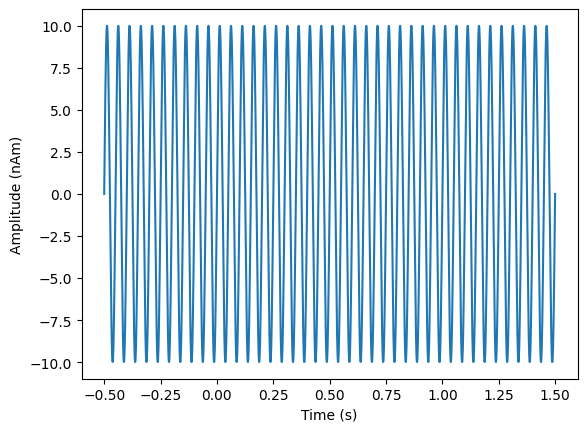

In [18]:
# Frequency of simulated sinusoid (Hz)
freq = 20
# Strength of simulated activity (nAm)
dipole_moment = 10
# Sampling rate (must match the data file)
s_rate = 2000

# Generate 1s of a sine wave at a sampling rate of 600Hz (to match the data file)
time = np.linspace(-.5,1.5,s_rate+1)
sim_signal = np.sin(time*freq*2*np.pi).reshape(1,-1)

plt.plot(time,dipole_moment*sim_signal[0,:])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (nAm)')

In [19]:
pial_ds_mesh_fname = '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii'
pial_ds_mesh = nib.load(pial_ds_mesh_fname)
pial_coord = pial_ds_mesh.darrays[0].data[sim_vertex,:]
pial_mesh_fname = '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.gii'
pial_mesh = nib.load(pial_mesh_fname)
cam_view = [152, 28, 15,
            3.5, 26, 38.5,
            0, 0, 1]
plot = show_surface(
    pial_mesh, 
    opacity=1, 
    coords=pial_coord,
    coord_size=2,
    camera_view=cam_view
)

Output()

In [22]:
# Size of simulated patch of activity (mm)
sim_patch_size = 5
SNR=-5

In [30]:
# Now simulate at the corresponding vertex on each layer, and for each simulation, run model comparison across
# all layers
err_layerF = []
for err in err_levels:
    
    all_layerF = []

    for l in range(n_layers):        
        print(f'Simulating in layer {l}')
        l_vertex = l*verts_per_surf+sim_vertex
        prefix = f'sim_{sim_vertex}_{l}_'

        l_sim_fname = run_current_density_simulation(
            base_fname, 
            prefix, 
            l_vertex, 
            sim_signal, 
            dipole_moment, 
            sim_patch_size, 
            SNR,
            spm_instance=spm
        ) 
        
        # Translation vector
        translation = err
        shift_vec = np.random.randn(3)
        shift_vec = shift_vec / np.linalg.norm(shift_vec) * translation

        # Rotation vector
        rotation_rad = err * np.pi / 180.0
        rot_vec = np.random.randn(3)
        rot_vec = rot_vec / np.linalg.norm(rot_vec) * rotation_rad

        # Apply transformation to fiducial locations
        P = np.concatenate((shift_vec, rot_vec))
        rotation = R.from_rotvec(P[3:])
        rotation_matrix = rotation.as_matrix()
        A = np.eye(4)
        A[:3, :3] = rotation_matrix
        A[:3, 3] = P[:3]

        # Transform zero_mean_fid
        new_fid_homogeneous = (A @ zero_mean_fid.T).T
        new_fid = new_fid_homogeneous[:, :3] + mean_fid

        [layerF,_] = model_comparison(
            new_fid[0,:], 
            new_fid[1,:], 
            new_fid[2,:], 
            mri_fname, 
            layer_fnames, 
            l_sim_fname, 
            viz=False,
            spm_instance=spm,
            coregister_kwargs={
                'fid_labels': ['Nasion','LPA','RPA']
            },
            invert_kwargs={
                'patch_size': patch_size, 
                'n_temp_modes': n_temp_modes        
            }
        )
        all_layerF.append(layerF)
    all_layerF = np.array(all_layerF)
    err_layerF.append(all_layerF)
err_layerF=np.array(err_layerF)

Simulating in layer 0
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_0_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 526.76 pAm/mm2, peak momemnt density 1280.64 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 526.76, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1280.64, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_0_Pspm_p001_t1_ru



------------------------------------------------------------------------
27-Jul-2024 11:43:17 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:43:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      11:44:29 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 11:45:39 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:45:39 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           11:45:54 - 27/07/2024
Completed                               :          11:45:54 - 27/07/2024
27-Jul-2024 11:45:55 - Done    'Head model specification'
27-Jul-2024 11:45:55 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.86)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 11:47:01 - Done    'Source inversion, iterative'
27-Jul-2024 11:47:01 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 11:47:03 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:47:03 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           11:47:24 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.492601e+04 [+4.12]
  ReML Iteration 2                      :        ...1.420519e+04 [+4.25]
  ReML Iteration 3                      :        ...1.305580e+04 [+4.38]
  ReML Iteration 4                      :        ...1.093221e+04 [+4.50]
  ReML Iteration 5                      :        ...1.401598e+02 [+4.62]
  ReML Iteration 6                      :        ...5.346983e-02 [+4.75]
  ReML Iteration 7                      :        ...5.474023e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.492601e+04 [+4.12]
  ReML Iteration 2                      :        ...1.420519e+04 [+4.25]
  ReML Iteration 3                      :        ...1.305580e+04 [+4.38]
  ReML Iteration 4                      :        ...1.093221e+04 [+4.50]
  ReML Iteration 5                      :        ...1.401598e+02 [+4.62]
  ReML Iteration 6                      :        ...5.346983e-02 



------------------------------------------------------------------------
27-Jul-2024 11:49:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:49:51 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 11:53:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:53:02 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           11:53:17 - 27/07/2024
Completed                               :          11:53:17 - 27/07/2024
27-Jul-2024 11:53:17 - Done    'Head model specification'
27-Jul-2024 11:53:17 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (50.83)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 11:54:25 - Done    'Source inversion, iterative'
27-Jul-2024 11:54:25 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 11:54:27 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:54:27 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           11:54:43 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.489484e+04 [+4.12]
  ReML Iteration 2                      :        ...1.417800e+04 [+4.25]
  ReML Iteration 3                      :        ...1.304597e+04 [+4.38]
  ReML Iteration 4                      :        ...1.095261e+04 [+4.50]
  ReML Iteration 5                      :        ...1.612375e+02 [+4.62]
  ReML Iteration 6                      :        ...3.897265e-02 [+4.75]
  ReML Iteration 7                      :        ...5.088118e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.489484e+04 [+4.12]
  ReML Iteration 2                      :        ...1.417800e+04 [+4.25]
  ReML Iteration 3                      :        ...1.304597e+04 [+4.38]
  ReML Iteration 4                      :        ...1.095261e+04 [+4.50]
  ReML Iteration 5                      :        ...1.612375e+02 [+4.62]
  ReML Iteration 6                      :        ...3.897265e-02 



------------------------------------------------------------------------
27-Jul-2024 11:57:03 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:57:03 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      11:58:17 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 11:59:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 11:59:28 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           11:59:44 - 27/07/2024
Completed                               :          11:59:44 - 27/07/2024
27-Jul-2024 11:59:44 - Done    'Head model specification'
27-Jul-2024 11:59:44 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.527003e+04 [+4.12]
  ReML Iteration 2                      :        ...1.454880e+04 [+4.25]
  ReML Iteration 3                      :        ...1.342888e+04 [+4.38]
  ReML Iteration 4                      :        ...1.132779e+04 [+4.50]
  ReML Iteration 5                      :        ...2.853579e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:04:10 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:04:10 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 



------------------------------------------------------------------------
27-Jul-2024 12:05:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:05:19 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:05:35 - 27/07/2024
Completed                               :          12:05:35 - 27/07/2024
27-Jul-2024 12:05:36 - Done    'Head model specification'
27-Jul-2024 12:05:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:06:42 - Done    'Source inversion, iterative'
27-Jul-2024 12:06:42 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:06:43 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:06:43 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:06:58 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.488401e+04 [+4.12]
  ReML Iteration 2                      :        ...1.416223e+04 [+4.25]
  ReML Iteration 3                      :        ...1.301069e+04 [+4.38]
  ReML Iteration 4                      :        ...1.088955e+04 [+4.50]
  ReML Iteration 5                      :        ...1.322464e+02 [+4.62]
  ReML Iteration 6                      :        ...4.029617e-02 [+4.75]
  ReML Iteration 7                      :        ...3.896647e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.488401e+04 [+4.12]
  ReML Iteration 2                      :        ...1.416223e+04 [+4.25]
  ReML Iteration 3                      :        ...1.301069e+04 [+4.38]
  ReML Iteration 4                      :        ...1.088955e+04 [+4.50]
  ReML Iteration 5                      :        ...1.322464e+02 [+4.62]
  ReML Iteration 6                      :        ...4.029617e-02 



------------------------------------------------------------------------
27-Jul-2024 12:09:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:09:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 12:12:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:12:24 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:12:43 - 27/07/2024
Completed                               :          12:12:43 - 27/07/2024
27-Jul-2024 12:12:43 - Done    'Head model specification'
27-Jul-2024 12:12:43 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.99 (50.86)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:13:56 - Done    'Source inversion, iterative'
27-Jul-2024 12:13:56 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:13:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:13:58 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:14:16 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.568046e+04 [+4.12]
  ReML Iteration 2                      :        ...1.503771e+04 [+4.25]
  ReML Iteration 3                      :        ...1.393468e+04 [+4.38]
  ReML Iteration 4                      :        ...1.181750e+04 [+4.50]
  ReML Iteration 5                      :        ...3.404087e+02 [+4.62]
  ReML Iteration 6                      :        ...4.048225e-01 [+4.75]
  ReML Iteration 7                      :        ...1.942668e-02 [+4.88]
  ReML Iteration 8                      :        ...1.006784e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.568046e+04 [+4.12]
  ReML Iteration 2                      :        ...1.503771e+04 [+4.25]
  ReML Iteration 3                      :        ...1.393468e+04 [+4.38]
  ReML Iteration 4                      :        ...1.181750e+04 [+4.50]
  ReML Iteration 5                      :        ...3.404087e+02 



------------------------------------------------------------------------
27-Jul-2024 12:16:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:16:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      12:18:04 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 12:19:22 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:19:22 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:19:37 - 27/07/2024
Completed                               :          12:19:37 - 27/07/2024
27-Jul-2024 12:19:38 - Done    'Head model specification'
27-Jul-2024 12:19:38 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.86)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:20:42 - Done    'Source inversion, iterative'
27-Jul-2024 12:20:42 - Done

Simulating in layer 4
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_4_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 524.22 pAm/mm2, peak momemnt density 1448.43 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 12:23:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:23:59 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.93 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      12:25:09 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 12:26:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:26:12 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:26:26 - 27/07/2024
Completed                               :          12:26:26 - 27/07/2024
27-Jul-2024 12:26:27 - Done    'Head model specification'
27-Jul-2024 12:26:27 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.92)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:27:29 - Done    'Source inversion, iterative'
27-Jul-2024 12:27:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:27:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:27:29 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:27:43 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.481395e+04 [+4.12]
  ReML Iteration 2                      :        ...1.407822e+04 [+4.25]
  ReML Iteration 3                      :        ...1.291050e+04 [+4.38]
  ReML Iteration 4                      :        ...1.078432e+04 [+4.50]
  ReML Iteration 5                      :        ...1.025242e+02 [+4.62]
  ReML Iteration 6                      :        ...1.969625e-02 [+4.75]
  ReML Iteration 7                      :        ...1.443585e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.481395e+04 [+4.12]
  ReML Iteration 2                      :        ...1.407822e+04 [+4.25]
  ReML Iteration 3                      :        ...1.291050e+04 [+4.38]
  ReML Iteration 4                      :        ...1.078432e+04 [+4.50]
  ReML Iteration 5                      :        ...1.025242e+02 [+4.62]
  ReML Iteration 6                      :        ...1.969625e-02 



------------------------------------------------------------------------
27-Jul-2024 12:29:50 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:29:50 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.93 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 12:32:49 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:32:49 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:33:03 - 27/07/2024
Completed                               :          12:33:03 - 27/07/2024
27-Jul-2024 12:33:03 - Done    'Head model specification'
27-Jul-2024 12:33:03 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.98)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:34:05 - Done    'Source inversion, iterative'
27-Jul-2024 12:34:06 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:34:06 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:34:06 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:34:20 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.554320e+04 [+4.12]
  ReML Iteration 2                      :        ...1.485976e+04 [+4.25]
  ReML Iteration 3                      :        ...1.375061e+04 [+4.38]
  ReML Iteration 4                      :        ...1.164411e+04 [+4.50]
  ReML Iteration 5                      :        ...3.421587e+02 [+4.62]
  ReML Iteration 6                      :        ...2.549271e-01 [+4.75]
  ReML Iteration 7                      :        ...1.114967e-02 [+4.88]
  ReML Iteration 8                      :        ...5.175353e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.554320e+04 [+4.12]
  ReML Iteration 2                      :        ...1.485976e+04 [+4.25]
  ReML Iteration 3                      :        ...1.375061e+04 [+4.38]
  ReML Iteration 4                      :        ...1.164411e+04 [+4.50]
  ReML Iteration 5                      :        ...3.421587e+02 



------------------------------------------------------------------------
27-Jul-2024 12:36:26 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:36:26 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      12:37:46 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 12:39:01 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:39:01 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:39:15 - 27/07/2024
Completed                               :          12:39:15 - 27/07/2024
27-Jul-2024 12:39:15 - Done    'Head model specification'
27-Jul-2024 12:39:15 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.517506e+04 [+4.12]
  ReML Iteration 2                      :        ...1.446092e+04 [+4.25]
  ReML Iteration 3                      :        ...1.335367e+04 [+4.38]
  ReML Iteration 4                      :        ...1.127109e+04 [+4.50]
  ReML Iteration 5                      :        ...2.940302e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:43:32 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:43:32 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:44:42 - 27/07/2024
Completed                               :          12:44:42 - 27/07/2024
27-Jul-2024 12:44:42 - Done    'Head model specification'
27-Jul-2024 12:44:42 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      12:44:43 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.99 (51.11)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:45:54 - Done    'Source inversion, iterative'
27-Jul-2024 12:45:54 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:45:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:45:55 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:46:09 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.538748e+04 [+4.12]
  ReML Iteration 2                      :        ...1.468298e+04 [+4.25]
  ReML Iteration 3                      :        ...1.357154e+04 [+4.38]
  ReML Iteration 4                      :        ...1.146733e+04 [+4.50]
  ReML Iteration 5                      :        ...3.080390e+02 [+4.62]
  ReML Iteration 6                      :        ...1.218781e-01 [+4.75]
  ReML Iteration 7                      :        ...4.434731e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.538748e+04 [+4.12]
  ReML Iteration 2                      :        ...1.468298e+04 [+4.25]
  ReML Iteration 3                      :        ...1.357154e+04 [+4.38]
  ReML Iteration 4                    



------------------------------------------------------------------------
27-Jul-2024 12:48:15 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:48:15 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.11 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 12:51:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:51:12 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:51:32 - 27/07/2024
Completed                               :          12:51:32 - 27/07/2024
27-Jul-2024 12:51:33 - Done    'Head model specification'
27-Jul-2024 12:51:33 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.99 (51.22)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:52:36 - Done    'Source inversion, iterative'
27-Jul-2024 12:52:36 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 12:52:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:52:37 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:52:51 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.534609e+04 [+4.12]
  ReML Iteration 2                      :        ...1.464125e+04 [+4.25]
  ReML Iteration 3                      :        ...1.353958e+04 [+4.38]
  ReML Iteration 4                      :        ...1.145768e+04 [+4.50]
  ReML Iteration 5                      :        ...3.237796e+02 [+4.62]
  ReML Iteration 6                      :        ...9.442658e-02 [+4.75]
  ReML Iteration 7                      :        ...3.698005e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.534609e+04 [+4.12]
  ReML Iteration 2                      :        ...1.464125e+04 [+4.25]
  ReML Iteration 3                      :        ...1.353958e+04 [+4.38]
  ReML Iteration 4                      :        ...1.145768e+04 [+4.50]
  ReML Iteration 5                      :        ...3.237796e+02 [+4.62]
  ReML Iteration 6                      :        ...9.442658e-02 



------------------------------------------------------------------------
27-Jul-2024 12:55:18 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:55:18 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      12:56:29 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 12:57:41 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 12:57:41 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           12:57:58 - 27/07/2024
Completed                               :          12:57:58 - 27/07/2024
27-Jul-2024 12:57:59 - Done    'Head model specification'
27-Jul-2024 12:57:59 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (51.21)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 12:59:07 - Done    'Source inversion, iterative'
27-Jul-2024 12:59:07 - Done

Simulating in layer 8
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.56 pAm/mm2, peak momemnt density 1592.88 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 13:02:10 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:02:10 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.47 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      13:03:21 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 13:04:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:04:25 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:04:39 - 27/07/2024
Completed                               :          13:04:39 - 27/07/2024
27-Jul-2024 13:04:40 - Done    'Head model specification'
27-Jul-2024 13:04:40 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.46)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 13:05:45 - Done    'Source inversion, iterative'
27-Jul-2024 13:05:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 13:05:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:05:46 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:06:03 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.570587e+04 [+4.12]
  ReML Iteration 2                      :        ...1.508315e+04 [+4.25]
  ReML Iteration 3                      :        ...1.400101e+04 [+4.38]
  ReML Iteration 4                      :        ...1.190712e+04 [+4.50]
  ReML Iteration 5                      :        ...3.314097e+02 [+4.62]
  ReML Iteration 6                      :        ...5.931503e-01 [+4.75]
  ReML Iteration 7                      :        ...2.632975e-02 [+4.88]
  ReML Iteration 8                      :        ...1.288992e-03 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.570587e+04 [+4.12]
  ReML Iteration 2                      :        ...1.508315e+04 [+4.25]
  ReML Iteration 3                      :        ...1.400101e+04 [+4.38]
  ReML Iteration 4                      :        ...1.190712e+04 [+4.50]
  ReML Iteration 5                      :        ...3.314097e+02 



------------------------------------------------------------------------
27-Jul-2024 13:08:18 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:08:18 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.47 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 13:11:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:11:19 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:11:33 - 27/07/2024
Completed                               :          13:11:33 - 27/07/2024
27-Jul-2024 13:11:34 - Done    'Head model specification'
27-Jul-2024 13:11:34 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.56)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 13:12:45 - Done    'Source inversion, iterative'
27-Jul-2024 13:12:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 13:12:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:12:46 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:13:03 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.501826e+04 [+4.12]
  ReML Iteration 2                      :        ...1.432104e+04 [+4.25]
  ReML Iteration 3                      :        ...1.321679e+04 [+4.38]
  ReML Iteration 4                      :        ...1.115546e+04 [+4.50]
  ReML Iteration 5                      :        ...2.291289e+02 [+4.62]
  ReML Iteration 6                      :        ...2.654310e-02 [+4.75]
  ReML Iteration 7                      :        ...6.103164e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.501826e+04 [+4.12]
  ReML Iteration 2                      :        ...1.432104e+04 [+4.25]
  ReML Iteration 3                      :        ...1.321679e+04 [+4.38]
  ReML Iteration 4                      :        ...1.115546e+04 [+4.50]
  ReML Iteration 5                      :        ...2.291289e+02 [+4.62]
  ReML Iteration 6                      :        ...2.654310e-02 



------------------------------------------------------------------------
27-Jul-2024 13:15:17 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:15:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.57 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      13:16:37 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 13:17:42 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:17:42 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:17:56 - 27/07/2024
Completed                               :          13:17:56 - 27/07/2024
27-Jul-2024 13:17:56 - Done    'Head model specification'
27-Jul-2024 13:17:56 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.477054e+04 [+4.12]
  ReML Iteration 2                      :        ...1.405815e+04 [+4.25]
  ReML Iteration 3                      :        ...1.292921e+04 [+4.38]
  ReML Iteration 4                      :        ...1.087867e+04 [+4.50]
  ReML Iteration 5                      :        ...1.342399e+02 [+4.62]
  ReML Iteration 6            



------------------------------------------------------------------------
27-Jul-2024 13:22:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:22:16 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 13:23:34 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:23:35 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

Completed                               :          13:24:51 - 27/07/2024
27-Jul-2024 13:24:51 - Done    'Head model specification'
27-Jul-2024 13:24:51 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      13:24:52 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MA

Percent variance explained 99.99 (51.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 13:26:03 - Done    'Source inversion, iterative'
27-Jul-2024 13:26:03 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 13:26:04 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:26:04 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:26:18 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.498844e+04 [+4.12]
  ReML Iteration 2                      :        ...1.428404e+04 [+4.25]
  ReML Iteration 3                      :        ...1.317205e+04 [+4.38]
  ReML Iteration 4                      :        ...1.111487e+04 [+4.50]
  ReML Iteration 5                      :        ...1.818634e+02 [+4.62]
  ReML Iteration 6                      :        ...1.996678e-02 [+4.75]
  ReML Iteration 7                      :        ...3.389250e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.498844e+04 [+4.12]
  ReML Iteration 2                      :        ...1.428404e+04 [+4.25]
  ReML Iteration 3                      :        ...1.317205e+04 [+4.38]
  ReML Iteration 4                      :        ...1.111487e+04 [+4.50]
  ReML Iteration 5                      :        ...1.818634e+02 [+4.62]
  ReML Iteration 6                      :        ...1.996678e-02 

Completed                               :          13:30:22 - 27/07/2024
27-Jul-2024 13:30:23 - Done    'Head model specification'
27-Jul-2024 13:30:23 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      13:30:23 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB

Percent variance explained 99.99 (50.85)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 13:31:33 - Done    'Source inversion, iterative'
27-Jul-2024 13:31:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 13:31:34 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:31:34 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:31:49 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.518684e+04 [+4.12]
  ReML Iteration 2                      :        ...1.446082e+04 [+4.25]
  ReML Iteration 3                      :        ...1.332967e+04 [+4.38]
  ReML Iteration 4                      :        ...1.121595e+04 [+4.50]
  ReML Iteration 5                      :        ...2.394653e+02 [+4.62]
  ReML Iteration 6                      :        ...3.613856e-02 [+4.75]
  ReML Iteration 7                      :        ...9.192907e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.518684e+04 [+4.12]
  ReML Iteration 2                      :        ...1.446082e+04 [+4.25]
  ReML Iteration 3                      :        ...1.332967e+04 [+4.38]
  ReML Iteration 4                      :        ...1.121595e+04 [+4.50]
  ReML Iteration 5                      :        ...2.394653e+02 [+4.62]
  ReML Iteration 6                      :        ...3.613856e-02 



------------------------------------------------------------------------
27-Jul-2024 13:33:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:33:58 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      13:35:08 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 13:36:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:36:12 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:36:31 - 27/07/2024
Completed                               :          13:36:31 - 27/07/2024
27-Jul-2024 13:36:32 - Done    'Head model specification'
27-Jul-2024 13:36:32 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 13:37:49 - Done    'Source inversion, iterative'
27-Jul-2024 13:37:49 - Done

Simulating in layer 1
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_1_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 577.90 pAm/mm2, peak momemnt density 1369.32 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 13:41:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:41:00 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      13:42:11 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 13:43:23 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:43:23 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:43:40 - 27/07/2024
Completed                               :          13:43:40 - 27/07/2024
27-Jul-2024 13:43:40 - Done    'Head model specification'
27-Jul-2024 13:43:40 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 13:44:50 - Done    'Source inversion, iterative'
27-Jul-2024 13:44:50 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 13:44:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:44:51 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:45:05 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.500416e+04 [+4.12]
  ReML Iteration 2                      :        ...1.428584e+04 [+4.25]
  ReML Iteration 3                      :        ...1.314899e+04 [+4.38]
  ReML Iteration 4                      :        ...1.103122e+04 [+4.50]
  ReML Iteration 5                      :        ...1.751418e+02 [+4.62]
  ReML Iteration 6                      :        ...9.014959e-02 [+4.75]
  ReML Iteration 7                      :        ...1.217075e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.500416e+04 [+4.12]
  ReML Iteration 2                      :        ...1.428584e+04 [+4.25]
  ReML Iteration 3                      :        ...1.314899e+04 [+4.38]
  ReML Iteration 4                      :        ...1.103122e+04 [+4.50]
  ReML Iteration 5                      :        ...1.751418e+02 [+4.62]
  ReML Iteration 6                      :        ...9.014959e-02 



------------------------------------------------------------------------
27-Jul-2024 13:47:27 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:47:27 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 13:50:18 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:50:18 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:50:32 - 27/07/2024
Completed                               :          13:50:32 - 27/07/2024
27-Jul-2024 13:50:32 - Done    'Head model specification'
27-Jul-2024 13:50:32 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (50.87)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 13:51:34 - Done    'Source inversion, iterative'
27-Jul-2024 13:51:34 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 13:51:35 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:51:35 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:51:54 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.508225e+04 [+4.12]
  ReML Iteration 2                      :        ...1.435316e+04 [+4.25]
  ReML Iteration 3                      :        ...1.321188e+04 [+4.38]
  ReML Iteration 4                      :        ...1.109282e+04 [+4.50]
  ReML Iteration 5                      :        ...1.862968e+02 [+4.62]
  ReML Iteration 6                      :        ...4.454248e-02 [+4.75]
  ReML Iteration 7                      :        ...7.572662e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.508225e+04 [+4.12]
  ReML Iteration 2                      :        ...1.435316e+04 [+4.25]
  ReML Iteration 3                      :        ...1.321188e+04 [+4.38]
  ReML Iteration 4                      :        ...1.109282e+04 [+4.50]
  ReML Iteration 5                      :        ...1.862968e+02 [+4.62]
  ReML Iteration 6                      :        ...4.454248e-02 



------------------------------------------------------------------------
27-Jul-2024 13:54:17 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:54:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.88 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      13:55:29 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 13:56:50 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 13:56:50 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           13:57:06 - 27/07/2024
Completed                               :          13:57:06 - 27/07/2024
27-Jul-2024 13:57:07 - Done    'Head model specification'
27-Jul-2024 13:57:07 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.79 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.506103e+04 [+4.12]
  ReML Iteration 2                      :        ...1.434438e+04 [+4.25]
  ReML Iteration 3                      :        ...1.322506e+04 [+4.38]
  ReML Iteration 4                      :        ...1.112921e+04 [+4.50]
  ReML Iteration 5                      :        ...2.545692e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:01:17 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:01:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:02:26 - 27/07/2024
Completed                               :          14:02:27 - 27/07/2024
27-Jul-2024 14:02:27 - Done    'Head model specification'
27-Jul-2024 14:02:27 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      14:02:27 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (50.78)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 14:03:29 - Done    'Source inversion, iterative'
27-Jul-2024 14:03:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:03:30 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:03:30 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:03:44 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.490828e+04 [+4.12]
  ReML Iteration 2                      :        ...1.418791e+04 [+4.25]
  ReML Iteration 3                      :        ...1.304092e+04 [+4.38]
  ReML Iteration 4                      :        ...1.092080e+04 [+4.50]
  ReML Iteration 5                      :        ...1.535207e+02 [+4.62]
  ReML Iteration 6                      :        ...3.353822e-02 [+4.75]
  ReML Iteration 7                      :        ...4.194304e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.490828e+04 [+4.12]
  ReML Iteration 2                      :        ...1.418791e+04 [+4.25]
  ReML Iteration 3                      :        ...1.304092e+04 [+4.38]
  ReML Iteration 4                      :        ...1.092080e+04 [+4.50]
  ReML Iteration 5                      :        ...1.535207e+02 [+4.62]
  ReML Iteration 6                      :        ...3.353822e-02 



------------------------------------------------------------------------
27-Jul-2024 14:06:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:06:12 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.79 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 14:09:04 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:09:04 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:09:25 - 27/07/2024
Completed                               :          14:09:25 - 27/07/2024
27-Jul-2024 14:09:25 - Done    'Head model specification'
27-Jul-2024 14:09:25 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (50.94)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 14:10:28 - Done    'Source inversion, iterative'
27-Jul-2024 14:10:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:10:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:10:29 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:10:43 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.526445e+04 [+4.12]
  ReML Iteration 2                      :        ...1.455636e+04 [+4.25]
  ReML Iteration 3                      :        ...1.345056e+04 [+4.38]
  ReML Iteration 4                      :        ...1.135848e+04 [+4.50]
  ReML Iteration 5                      :        ...3.152436e+02 [+4.62]
  ReML Iteration 6                      :        ...8.621182e-02 [+4.75]
  ReML Iteration 7                      :        ...3.137981e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.526445e+04 [+4.12]
  ReML Iteration 2                      :        ...1.455636e+04 [+4.25]
  ReML Iteration 3                      :        ...1.345056e+04 [+4.38]
  ReML Iteration 4                      :        ...1.135848e+04 [+4.50]
  ReML Iteration 5                      :        ...3.152436e+02 [+4.62]
  ReML Iteration 6                      :        ...8.621182e-02 



------------------------------------------------------------------------
27-Jul-2024 14:12:48 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:12:49 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      14:14:04 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 14:15:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:15:25 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:15:39 - 27/07/2024
Completed                               :          14:15:39 - 27/07/2024
27-Jul-2024 14:15:40 - Done    'Head model specification'
27-Jul-2024 14:15:40 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.94)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 14:16:42 - Done    'Source inversion, iterative'
27-Jul-2024 14:16:42 - Done

Simulating in layer 5
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_5_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 520.77 pAm/mm2, peak momemnt density 1549.45 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 14:19:45 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:19:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:21:03 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:21:03 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:22:17 - 27/07/2024
Completed                               :          14:22:17 - 27/07/2024
27-Jul-2024 14:22:17 - Done    'Head model specification'
27-Jul-2024 14:22:17 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      14:22:18 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (50.94)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 14:23:22 - Done    'Source inversion, iterative'
27-Jul-2024 14:23:22 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:23:23 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:23:23 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:23:40 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.479424e+04 [+4.12]
  ReML Iteration 2                      :        ...1.407415e+04 [+4.25]
  ReML Iteration 3                      :        ...1.291572e+04 [+4.38]
  ReML Iteration 4                      :        ...1.081390e+04 [+4.50]
  ReML Iteration 5                      :        ...1.026995e+02 [+4.62]
  ReML Iteration 6                      :        ...1.273549e-02 [+4.75]
  ReML Iteration 7                      :        ...9.800718e-05 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.479424e+04 [+4.12]
  ReML Iteration 2                      :        ...1.407415e+04 [+4.25]
  ReML Iteration 3                      :        ...1.291572e+04 [+4.38]
  ReML Iteration 4                      :        ...1.081390e+04 [+4.50]
  ReML Iteration 5                      :        ...1.026995e+02 [+4.62]
  ReML Iteration 6                      :        ...1.273549e-02 



------------------------------------------------------------------------
27-Jul-2024 14:26:01 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:26:01 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.95 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 14:29:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:29:00 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:29:14 - 27/07/2024
Completed                               :          14:29:15 - 27/07/2024
27-Jul-2024 14:29:15 - Done    'Head model specification'
27-Jul-2024 14:29:15 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.15)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 14:30:18 - Done    'Source inversion, iterative'
27-Jul-2024 14:30:18 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:30:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:30:19 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:30:35 - 2

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.511648e+04 [+4.12]
  ReML Iteration 2                      :        ...1.439878e+04 [+4.25]
  ReML Iteration 3                      :        ...1.327275e+04 [+4.38]
  ReML Iteration 4                      :        ...1.117111e+04 [+4.50]
  ReML Iteration 5                      :        ...2.160564e+02 [+4.62]
  ReML Iteration 6                      :        ...5.551629e-02 [+4.75]
  ReML Iteration 7                      :        ...1.147390e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.511648e+04 [+4.12]
  ReML Iteration 2                      :        ...1.439878e+04 [+4.25]
  ReML Iteration 3                      :        ...1.327275e+04 [+4.38]
  ReML Iteration 4                      :        ...1.117111e+04 [+4.50]
  ReML Iteration 5                      :        ...2.160564e+02 [+4.62]
  ReML Iteration 6                     



------------------------------------------------------------------------
27-Jul-2024 14:33:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:33:02 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.16 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      14:34:14 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 14:35:32 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:35:32 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:35:46 - 27/07/2024
Completed                               :          14:35:47 - 27/07/2024
27-Jul-2024 14:35:47 - Done    'Head model specification'
27-Jul-2024 14:35:47 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.25 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.500372e+04 [+4.12]
  ReML Iteration 2                      :        ...1.429143e+04 [+4.25]
  ReML Iteration 3                      :        ...1.317785e+04 [+4.38]
  ReML Iteration 4                      :        ...1.110349e+04 [+4.50]
  ReML Iteration 5                      :        ...2.261491e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:39:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:39:51 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:41:19 - 27/07/2024
Completed                               :          14:41:20 - 27/07/2024
27-Jul-2024 14:41:20 - Done    'Head model specification'
27-Jul-2024 14:41:20 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      14:41:21 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (51.24)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 14:42:29 - Done    'Source inversion, iterative'
27-Jul-2024 14:42:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:42:30 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:42:30 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:42:44 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.530000e+04 [+4.12]
  ReML Iteration 2                      :        ...1.459469e+04 [+4.25]
  ReML Iteration 3                      :        ...1.348819e+04 [+4.38]
  ReML Iteration 4                      :        ...1.139606e+04 [+4.50]
  ReML Iteration 5                      :        ...2.881208e+02 [+4.62]
  ReML Iteration 6                      :        ...1.247337e-01 [+4.75]
  ReML Iteration 7                      :        ...3.922672e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.530000e+04 [+4.12]
  ReML Iteration 2                      :        ...1.459469e+04 [+4.25]
  ReML Iteration 3                      :        ...1.348819e+04 [+4.38]
  ReML Iteration 4                      :        ...1.139606e+04 [+4.50]
  ReML Iteration 5                      :        ...2.881208e+02 [+4.62]
  ReML Iteration 6                      :        ...1.247337e-01 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:46:14 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:46:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:49:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:49:37 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:50:03 - 27/07/2024
Completed                               :          14:50:04 - 27/07/2024
27-Jul-2024 14:50:05 - Done    'Head model specifi

Percent variance explained 99.98 (51.46)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 14:51:45 - Done    'Source inversion, iterative'
27-Jul-2024 14:51:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 14:51:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:51:46 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:52:02 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.494375e+04 [+4.12]
  ReML Iteration 2                      :        ...1.423747e+04 [+4.25]
  ReML Iteration 3                      :        ...1.312151e+04 [+4.38]
  ReML Iteration 4                      :        ...1.104787e+04 [+4.50]
  ReML Iteration 5                      :        ...2.037107e+02 [+4.62]
  ReML Iteration 6                      :        ...2.148909e-02 [+4.75]
  ReML Iteration 7                      :        ...4.189229e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.494375e+04 [+4.12]
  ReML Iteration 2                      :        ...1.423747e+04 [+4.25]
  ReML Iteration 3                      :        ...1.312151e+04 [+4.38]
  ReML Iteration 4                      :        ...1.104787e+04 [+4.50]
  ReML Iteration 5                      :        ...2.037107e+02 [+4.62]
  ReML Iteration 6                      :        ...2.148909e-02 



------------------------------------------------------------------------
27-Jul-2024 14:54:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:54:53 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.47 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      14:56:25 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 14:58:09 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 14:58:09 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           14:58:39 - 27/07/2024
Completed                               :          14:58:39 - 27/07/2024
27-Jul-2024 14:58:40 - Done    'Head model specification'
27-Jul-2024 14:58:40 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (51.46)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 15:00:15 - Done    'Source inversion, iterative'
27-Jul-2024 15:00:15 - Done

Simulating in layer 9
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_9_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 516.45 pAm/mm2, peak momemnt density 1536.46 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 15:04:44 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:04:44 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.57 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:06:19 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 15:07:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:07:53 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:08:22 - 27/07/2024
Completed                               :          15:08:22 - 27/07/2024
27-Jul-2024 15:08:23 - Done    'Head model specification'
27-Jul-2024 15:08:23 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.56)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 15:09:57 - Done    'Source inversion, iterative'
27-Jul-2024 15:09:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 15:09:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:09:59 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:10:23 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.497716e+04 [+4.12]
  ReML Iteration 2                      :        ...1.426980e+04 [+4.25]
  ReML Iteration 3                      :        ...1.314255e+04 [+4.38]
  ReML Iteration 4                      :        ...1.106766e+04 [+4.50]
  ReML Iteration 5                      :        ...1.542648e+02 [+4.62]
  ReML Iteration 6                      :        ...2.601473e-02 [+4.75]
  ReML Iteration 7                      :        ...3.422149e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.497716e+04 [+4.12]
  ReML Iteration 2                      :        ...1.426980e+04 [+4.25]
  ReML Iteration 3                      :        ...1.314255e+04 [+4.38]
  ReML Iteration 4                      :        ...1.106766e+04 [+4.50]
  ReML Iteration 5                      :        ...1.542648e+02 [+4.62]
  ReML Iteration 6                      :        ...2.601473e-02 



------------------------------------------------------------------------
27-Jul-2024 15:13:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:13:02 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.57 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 15:17:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:17:00 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:17:29 - 27/07/2024
Completed                               :          15:17:29 - 27/07/2024
27-Jul-2024 15:17:30 - Done    'Head model specification'
27-Jul-2024 15:17:30 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.80)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 15:18:56 - Done    'Source inversion, iterative'
27-Jul-2024 15:18:56 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 15:18:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:18:58 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:19:14 - 2

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.483361e+04 [+4.12]
  ReML Iteration 2                      :        ...1.412720e+04 [+4.25]
  ReML Iteration 3                      :        ...1.299848e+04 [+4.38]
  ReML Iteration 4                      :        ...1.093030e+04 [+4.50]
  ReML Iteration 5                      :        ...1.481091e+02 [+4.62]
  ReML Iteration 6                      :        ...1.390599e-02 [+4.75]
  ReML Iteration 7                      :        ...1.748361e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.483361e+04 [+4.12]
  ReML Iteration 2                      :        ...1.412720e+04 [+4.25]
  ReML Iteration 3                      :        ...1.299848e+04 [+4.38]
  ReML Iteration 4                      :        ...1.093030e+04 [+4.50]
  ReML Iteration 5                      :        ...1.481091e+02 [+4.62]
  ReML Iteration 6                     



------------------------------------------------------------------------
27-Jul-2024 15:22:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:22:55 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.81 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:24:26 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


-----------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 15:26:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:26:00 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:26:28 - 27/07/2024
Completed                               :          15:26:28 - 27/07/2024
27-Jul-2024 15:26:29 - Done    'Head model specification'
27-Jul-2024 15:26:29 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.536609e+04 [+4.12]
  ReML Iteration 2                      :        ...1.465360e+04 [+4.25]
  ReML Iteration 3                      :        ...1.354063e+04 [+4.38]
  ReML Iteration 4                      :        ...1.144377e+04 [+4.50]
  ReML Iteration 5                      :        ...3.260890e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 15:32:23 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:32:23 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:33:59 - 27/07/2024
Completed                               :          15:34:00 - 27/07/2024
27-Jul-2024 15:34:00 - Done    'Head model specification'
27-Jul-2024 15:34:00 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:34:01 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (50.83)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 15:35:26 - Done    'Source inversion, iterative'
27-Jul-2024 15:35:26 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 15:35:27 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:35:27 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:35:46 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.493676e+04 [+4.12]
  ReML Iteration 2                      :        ...1.422686e+04 [+4.25]
  ReML Iteration 3                      :        ...1.309188e+04 [+4.38]
  ReML Iteration 4                      :        ...1.097853e+04 [+4.50]
  ReML Iteration 5                      :        ...1.705810e+02 [+4.62]
  ReML Iteration 6                      :        ...5.891873e-02 [+4.75]
  ReML Iteration 7                      :        ...8.055637e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.493676e+04 [+4.12]
  ReML Iteration 2                      :        ...1.422686e+04 [+4.25]
  ReML Iteration 3                      :        ...1.309188e+04 [+4.38]
  ReML Iteration 4                      :        ...1.097853e+04 [+4.50]
  ReML Iteration 5                      :        ...1.705810e+02 [+4.62]
  ReML Iteration 6                      :        ...5.891873e-02 



------------------------------------------------------------------------
27-Jul-2024 15:38:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:38:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 15:42:36 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:42:36 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:42:59 - 27/07/2024
Completed                               :          15:42:59 - 27/07/2024
27-Jul-2024 15:43:00 - Done    'Head model specification'
27-Jul-2024 15:43:00 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 15:44:42 - Done    'Source inversion, iterative'
27-Jul-2024 15:44:42 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 15:44:44 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:44:44 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:45:15 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.496297e+04 [+4.12]
  ReML Iteration 2                      :        ...1.424457e+04 [+4.25]
  ReML Iteration 3                      :        ...1.310932e+04 [+4.38]
  ReML Iteration 4                      :        ...1.099661e+04 [+4.50]
  ReML Iteration 5                      :        ...2.012335e+02 [+4.62]
  ReML Iteration 6                      :        ...1.785613e-02 [+4.75]
  ReML Iteration 7                      :        ...3.477035e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.496297e+04 [+4.12]
  ReML Iteration 2                      :        ...1.424457e+04 [+4.25]
  ReML Iteration 3                      :        ...1.310932e+04 [+4.38]
  ReML Iteration 4                      :        ...1.099661e+04 [+4.50]
  ReML Iteration 5                      :        ...2.012335e+02 [+4.62]
  ReML Iteration 6                      :        ...1.785613e-02 



------------------------------------------------------------------------
27-Jul-2024 15:48:20 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:48:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:50:33 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 15:52:15 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:52:15 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           15:52:32 - 27/07/2024
Completed                               :          15:52:33 - 27/07/2024
27-Jul-2024 15:52:33 - Done    'Head model specification'
27-Jul-2024 15:52:33 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 15:53:56 - Done    'Source inversion, iterative'
27-Jul-2024 15:53:56 - Done

Simulating in layer 2
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_2_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 542.21 pAm/mm2, peak momemnt density 1389.12 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 15:58:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 15:58:02 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      15:59:32 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 16:00:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:00:56 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:01:22 - 27/07/2024
Completed                               :          16:01:22 - 27/07/2024
27-Jul-2024 16:01:23 - Done    'Head model specification'
27-Jul-2024 16:01:23 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

  ReML Iteration 1                      :        ...1.488875e+04 [+4.12]
  ReML Iteration 2                      :        ...1.416696e+04 [+4.25]
  ReML Iteration 3                      :        ...1.301836e+04 [+4.38]
  ReML Iteration 4                      :        ...1.090623e+04 [+4.50]
  ReML Iteration 5                      :        ...1.355980e+02 [+4.62]
  ReML Iteration 6                      :        ...3.178121e-02 [+4.75]
  ReML Iteration 7                      :        ...3.314958e-04 [+4.88]
Percent variance explained 99.97 (50.83)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:03:29 - Done    'Source inversion, iterative'
27-Jul-2024 16:03:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.492760e+04 [+4.12]
  ReML Iteration 2                      :        ...1.420587e+04 [+4.25]
  ReML Iteration 3                      :        ...1.305449e+04 [+4.38]
  ReML Iteration 4                      :        ...1.093178e+04 [+4.50]
  ReML Iteration 5                      :        ...1.342791e+02 [+4.62]
  ReML Iteration 6           


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:06:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:06:55 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Percent variance explained 99.98 (50.83)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:10:30 - Done    'Source inversion, iterative'
27-Jul-2024 16:10:30 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:10:32 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:10:32 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:10:58 - 2

Percent variance explained 99.97 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:12:49 - Done    'Source inversion, iterative'
27-Jul-2024 16:12:49 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:12:50 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:12:50 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:13:08 - 2

Percent variance explained 99.97 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:14:34 - Done    'Source inversion, iterative'
27-Jul-2024 16:14:34 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:14:36 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:14:36 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:14:54 - 2

Percent variance explained 99.97 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:16:19 - Done    'Source inversion, iterative'
27-Jul-2024 16:16:19 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:16:21 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:16:21 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:16:46 - 2

Percent variance explained 99.96 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:18:09 - Done    'Source inversion, iterative'
27-Jul-2024 16:18:09 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:18:11 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:18:11 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:18:38 - 2

Percent variance explained 99.96 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:20:37 - Done    'Source inversion, iterative'
27-Jul-2024 16:20:37 - Done

Simulating in layer 4
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_4_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 524.22 pAm/mm2, peak momemnt density 1448.43 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 16:24:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:24:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:26:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:26:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:28:24 - 27/07/2024
Completed                               :          16:28:24 - 27/07/2024
27-Jul-2024 16:28:25 - Done    'Head model specification'
27-Jul-2024 16:28:25 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:28:26 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (50.96)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:29:55 - Done    'Source inversion, iterative'
27-Jul-2024 16:29:55 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:29:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:29:56 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:30:15 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.475449e+04 [+4.12]
  ReML Iteration 2                      :        ...1.401800e+04 [+4.25]
  ReML Iteration 3                      :        ...1.284016e+04 [+4.38]
  ReML Iteration 4                      :        ...1.071033e+04 [+4.50]
  ReML Iteration 5                      :        ...8.103635e+01 [+4.62]
  ReML Iteration 6                      :        ...1.482026e-02 [+4.75]
  ReML Iteration 7                      :        ...7.833589e-05 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.475449e+04 [+4.12]
  ReML Iteration 2                      :        ...1.401800e+04 [+4.25]
  ReML Iteration 3                      :        ...1.284016e+04 [+4.38]
  ReML Iteration 4                      :        ...1.071033e+04 [+4.50]
  ReML Iteration 5                      :        ...8.103635e+01 [+4.62]
  ReML Iteration 6                      :        ...1.482026e-02 



------------------------------------------------------------------------
27-Jul-2024 16:32:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:32:51 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 16:36:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:36:51 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:37:18 - 27/07/2024
Completed                               :          16:37:18 - 27/07/2024
27-Jul-2024 16:37:19 - Done    'Head model specification'
27-Jul-2024 16:37:19 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.99)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:38:38 - Done    'Source inversion, iterative'
27-Jul-2024 16:38:38 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:38:39 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:38:39 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:38:55 - 2

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.495575e+04 [+4.12]
  ReML Iteration 2                      :        ...1.423662e+04 [+4.25]
  ReML Iteration 3                      :        ...1.309163e+04 [+4.38]
  ReML Iteration 4                      :        ...1.097659e+04 [+4.50]
  ReML Iteration 5                      :        ...1.588681e+02 [+4.62]
  ReML Iteration 6                      :        ...3.276067e-02 [+4.75]
  ReML Iteration 7                      :        ...4.374643e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.495575e+04 [+4.12]
  ReML Iteration 2                      :        ...1.423662e+04 [+4.25]
  ReML Iteration 3                      :        ...1.309163e+04 [+4.38]
  ReML Iteration 4                      :        ...1.097659e+04 [+4.50]
  ReML Iteration 5                      :        ...1.588681e+02 [+4.62]
  ReML Iteration 6                     



------------------------------------------------------------------------
27-Jul-2024 16:42:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:42:28 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.00 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:43:51 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 16:45:36 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:45:36 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:46:05 - 27/07/2024
Completed                               :          16:46:06 - 27/07/2024
27-Jul-2024 16:46:06 - Done    'Head model specification'
27-Jul-2024 16:46:06 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.13 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.495635e+04 [+4.12]
  ReML Iteration 2                      :        ...1.423811e+04 [+4.25]
  ReML Iteration 3                      :        ...1.310450e+04 [+4.38]
  ReML Iteration 4                      :        ...1.101195e+04 [+4.50]
  ReML Iteration 5                      :        ...1.939766e+02 [+4.62]
  ReML Iteration 6            



------------------------------------------------------------------------
27-Jul-2024 16:50:52 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:50:53 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.13 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:52:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:52:12 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:53:23 - 27/07/2024
Completed                               :          16:53:23 - 27/07/2024
27-Jul-2024 16:53:24 - Done    'Head model specification'
27-Jul-2024 16:53:24 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:53:24 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (51.12)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 16:54:31 - Done    'Source inversion, iterative'
27-Jul-2024 16:54:31 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 16:54:32 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 16:54:32 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           16:54:49 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.491900e+04 [+4.12]
  ReML Iteration 2                      :        ...1.419075e+04 [+4.25]
  ReML Iteration 3                      :        ...1.303297e+04 [+4.38]
  ReML Iteration 4                      :        ...1.091818e+04 [+4.50]
  ReML Iteration 5                      :        ...1.266711e+02 [+4.62]
  ReML Iteration 6                      :        ...1.070529e-02 [+4.75]
  ReML Iteration 7                      :        ...1.152151e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.491900e+04 [+4.12]
  ReML Iteration 2                      :        ...1.419075e+04 [+4.25]
  ReML Iteration 3                      :        ...1.303297e+04 [+4.38]
  ReML Iteration 4                      :        ...1.091818e+04 [+4.50]
  ReML Iteration 5                      :        ...1.266711e+02 [+4.62]
  ReML Iteration 6                      :        ...1.070529e-02 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      16:59:17 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 17:00:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:00:29 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:00:43 - 27/07/2024
Completed                               :          17:00:43 - 27/07/2024
27-Jul-2024 17:00:44 - Done    'Head model specification'
27-Jul-2024 17:00:44 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (51.22)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:01:48 - Done    'Source inversion, iterative'
27-Jul-2024 17:01:48 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:01:49 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:01:49 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:02:06 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.500972e+04 [+4.12]
  ReML Iteration 2                      :        ...1.429045e+04 [+4.25]
  ReML Iteration 3                      :        ...1.316603e+04 [+4.38]
  ReML Iteration 4                      :        ...1.108412e+04 [+4.50]
  ReML Iteration 5                      :        ...2.017537e+02 [+4.62]
  ReML Iteration 6                      :        ...2.433960e-02 [+4.75]
  ReML Iteration 7                      :        ...4.702521e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.500972e+04 [+4.12]
  ReML Iteration 2                      :        ...1.429045e+04 [+4.25]
  ReML Iteration 3                      :        ...1.316603e+04 [+4.38]
  ReML Iteration 4                      :        ...1.108412e+04 [+4.50]
  ReML Iteration 5                      :        ...2.017537e+02 [+4.62]
  ReML Iteration 6                      :        ...2.433960e-02 



------------------------------------------------------------------------
27-Jul-2024 17:04:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:04:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:05:35 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.56 pAm/mm2, peak momemnt density 1592.88 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 532.56, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1592.88, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo/prior683788.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.40 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.494841e+04 [+4.12]
  ReML Iteration 2                      :        ...1.424942e+04 [+4.25]
  ReML Iteration 3                      :        ...1.314150e+04 [+4.38]
  ReML Iteration 4                      :        ...1.107479e+04 [+4.50]
  ReML Iteration 5                      :        ...2.344602e+02 [+4.62]
  ReML Iteration 6           


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:11:20 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:11:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:12:40 - 27/07/2024
Completed                               :          17:12:40 - 27/07/2024
27-Jul-2024 17:12:41 - Done    'Head model specification'
27-Jul-2024 17:12:41 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:12:41 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (51.40)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:13:45 - Done    'Source inversion, iterative'
27-Jul-2024 17:13:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:13:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:13:46 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:14:01 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.541328e+04 [+4.12]
  ReML Iteration 2                      :        ...1.471634e+04 [+4.25]
  ReML Iteration 3                      :        ...1.361297e+04 [+4.38]
  ReML Iteration 4                      :        ...1.152215e+04 [+4.50]
  ReML Iteration 5                      :        ...3.215144e+02 [+4.62]
  ReML Iteration 6                      :        ...1.504936e-01 [+4.75]
  ReML Iteration 7                      :        ...5.759806e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.541328e+04 [+4.12]
  ReML Iteration 2                      :        ...1.471634e+04 [+4.25]
  ReML Iteration 3                      :        ...1.361297e+04 [+4.38]
  ReML Iteration 4                      :        ...1.152215e+04 [+4.50]
  ReML Iteration 5                      :        ...3.215144e+02 [+4.62]
  ReML Iteration 6                      :        ...1.504936e-01 



------------------------------------------------------------------------
27-Jul-2024 17:16:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:16:29 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.40 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 17:19:32 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:19:32 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:19:46 - 27/07/2024
Completed                               :          17:19:46 - 27/07/2024
27-Jul-2024 17:19:46 - Done    'Head model specification'
27-Jul-2024 17:19:46 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (51.55)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:20:50 - Done    'Source inversion, iterative'
27-Jul-2024 17:20:50 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:20:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:20:51 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:21:05 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.481884e+04 [+4.12]
  ReML Iteration 2                      :        ...1.409499e+04 [+4.25]
  ReML Iteration 3                      :        ...1.295375e+04 [+4.38]
  ReML Iteration 4                      :        ...1.087771e+04 [+4.50]
  ReML Iteration 5                      :        ...1.193653e+02 [+4.62]
  ReML Iteration 6                      :        ...2.238288e-02 [+4.75]
  ReML Iteration 7                      :        ...2.002419e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.481884e+04 [+4.12]
  ReML Iteration 2                      :        ...1.409499e+04 [+4.25]
  ReML Iteration 3                      :        ...1.295375e+04 [+4.38]
  ReML Iteration 4                      :        ...1.087771e+04 [+4.50]
  ReML Iteration 5                      :        ...1.193653e+02 [+4.62]
  ReML Iteration 6                      :        ...2.238288e-02 



------------------------------------------------------------------------
27-Jul-2024 17:23:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:23:25 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.56 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:24:37 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 17:25:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:25:53 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:26:10 - 27/07/2024
Completed                               :          17:26:10 - 27/07/2024
27-Jul-2024 17:26:11 - Done    'Head model specification'
27-Jul-2024 17:26:11 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.480475e+04 [+4.12]
  ReML Iteration 2                      :        ...1.409010e+04 [+4.25]
  ReML Iteration 3                      :        ...1.296005e+04 [+4.38]
  ReML Iteration 4                      :        ...1.090859e+04 [+4.50]
  ReML Iteration 5                      :        ...1.360358e+02 [+4.62]
  ReML Iteration 6            



------------------------------------------------------------------------
27-Jul-2024 17:30:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:30:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:31:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:31:55 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

Completed                               :          17:33:05 - 27/07/2024
27-Jul-2024 17:33:05 - Done    'Head model specification'
27-Jul-2024 17:33:05 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:33:05 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MA



------------------------------------------------------------------------
27-Jul-2024 17:34:08 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:34:08 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:34:22 - 27/07/2024
Completed                               :          17:34:23 - 27/07/2024
27-Jul-2024 17:34:23 - Done    'Head model specification'
27-Jul-2024 17:34:23 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.81)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:35:27 - Done    'Source inversion, iterative'
27-Jul-2024 17:35:27 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:35:28 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:35:28 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:35:45 - 2



------------------------------------------------------------------------
27-Jul-2024 17:38:43 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:38:43 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:40:11 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:40:11 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          17:41:23 - 27/07/2024
27-Jul-2024 17:41:23 - Done    'Head model specification'
27-Jul-2024 17:41:23 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:41:24 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:42:43 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:42:43 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:42:58 - 27/07/2024
Completed                               :          17:42:58 - 27/07/2024
27-Jul-2024 17:42:58 - Done    'Head model specification'
27-Jul-2024 17:42:58 - Done

Smoothing /hom

Percent variance explained 99.96 (50.85)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:44:01 - Done    'Source inversion, iterative'
27-Jul-2024 17:44:01 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:44:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:44:02 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:44:17 - 2

Percent variance explained 99.95 (50.85)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:45:32 - Done    'Source inversion, iterative'
27-Jul-2024 17:45:32 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:45:33 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:45:33 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:45:47 - 2



------------------------------------------------------------------------
27-Jul-2024 17:48:45 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:48:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:50:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:50:16 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          17:51:27 - 27/07/2024
27-Jul-2024 17:51:27 - Done    'Head model specification'
27-Jul-2024 17:51:27 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      17:51:28 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

Percent variance explained 99.98 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:52:41 - Done    'Source inversion, iterative'
27-Jul-2024 17:52:41 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:52:43 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:52:43 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:53:00 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.493879e+04 [+4.12]
  ReML Iteration 2                      :        ...1.420913e+04 [+4.25]
  ReML Iteration 3                      :        ...1.305915e+04 [+4.38]
  ReML Iteration 4                      :        ...1.094351e+04 [+4.50]
  ReML Iteration 5                      :        ...1.463966e+02 [+4.62]
  ReML Iteration 6                      :        ...2.269570e-02 [+4.75]
  ReML Iteration 7                      :        ...2.797370e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.493879e+04 [+4.12]
  ReML Iteration 2                      :        ...1.420913e+04 [+4.25]
  ReML Iteration 3                      :        ...1.305915e+04 [+4.38]
  ReML Iteration 4                      :        ...1.094351e+04 [+4.50]
  ReML Iteration 5                      :        ...1.463966e+02 [+4.62]
  ReML Iteration 6                      :        ...2.269570e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:55:14 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:55:14 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:58:06 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:58:06 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:58:23 - 27/07/2024
Completed                               :          17:58:24 - 27/07/2024
27-Jul-2024 17:58:24 - Done    'Head model specifi

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 17:59:28 - Done    'Source inversion, iterative'
27-Jul-2024 17:59:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 17:59:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 17:59:29 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           17:59:46 - 2

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:00:58 - Done    'Source inversion, iterative'
27-Jul-2024 18:00:58 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:00:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:00:59 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:01:14 - 2

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:02:18 - Done    'Source inversion, iterative'
27-Jul-2024 18:02:18 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:02:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:02:19 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:02:37 - 2

Percent variance explained 99.97 (50.83)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:03:55 - Done    'Source inversion, iterative'
27-Jul-2024 18:03:55 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:03:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:03:56 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:04:10 - 2

Percent variance explained 99.96 (50.83)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:05:13 - Done    'Source inversion, iterative'
27-Jul-2024 18:05:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:05:14 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:05:14 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:05:29 - 2



------------------------------------------------------------------------
27-Jul-2024 18:08:20 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:08:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:09:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:09:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          18:10:47 - 27/07/2024
27-Jul-2024 18:10:47 - Done    'Head model specification'
27-Jul-2024 18:10:47 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:10:48 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:12:11 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:12:11 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:12:27 - 27/07/2024
Completed                               :          18:12:27 - 27/07/2024
27-Jul-2024 18:12:27 - Done    'Head model specification'
27-Jul-2024 18:12:27 - Done

Smoothing /hom

Percent variance explained 99.95 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:13:30 - Done    'Source inversion, iterative'
27-Jul-2024 18:13:30 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:13:31 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:13:31 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:13:45 - 2

Percent variance explained 99.95 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:14:56 - Done    'Source inversion, iterative'
27-Jul-2024 18:14:56 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:14:57 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:14:57 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:15:14 - 2



------------------------------------------------------------------------
27-Jul-2024 18:18:11 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:18:12 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.99 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:19:36 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 18:20:39 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:20:39 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:20:53 - 27/07/2024
Completed                               :          18:20:53 - 27/07/2024
27-Jul-2024 18:20:53 - Done    'Head model specification'
27-Jul-2024 18:20:53 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.97)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:22:03 - Done    'Source inversion, iterative'
27-Jul-2024 18:22:03 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:22:05 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:22:05 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:22:21 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.464663e+04 [+4.12]
  ReML Iteration 2                      :        ...1.392854e+04 [+4.25]
  ReML Iteration 3                      :        ...1.278672e+04 [+4.38]
  ReML Iteration 4                      :        ...1.070004e+04 [+4.50]
  ReML Iteration 5                      :        ...9.887353e+01 [+4.62]
  ReML Iteration 6                      :        ...2.974450e-02 [+4.75]
  ReML Iteration 7                      :        ...1.818516e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.464663e+04 [+4.12]
  ReML Iteration 2                      :        ...1.392854e+04 [+4.25]
  ReML Iteration 3                      :        ...1.278672e+04 [+4.38]
  ReML Iteration 4                      :        ...1.070004e+04 [+4.50]
  ReML Iteration 5                      :        ...9.887353e+01 [+4.62]
  ReML Iteration 6                      :        ...2.974450e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:24:32 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:24:32 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:27:21 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:27:21 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:27:42 - 27/07/2024
Completed                               :          18:27:42 - 27/07/2024
27-Jul-2024 18:27:43 - Done    'Head model specifi

Percent variance explained 99.97 (50.99)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:28:57 - Done    'Source inversion, iterative'
27-Jul-2024 18:28:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:28:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:28:58 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:29:12 - 2

Percent variance explained 99.97 (50.98)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:30:15 - Done    'Source inversion, iterative'
27-Jul-2024 18:30:15 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:30:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:30:16 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:30:30 - 2

Percent variance explained 99.97 (50.98)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:31:46 - Done    'Source inversion, iterative'
27-Jul-2024 18:31:46 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:31:47 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:31:47 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:32:03 - 2

Percent variance explained 99.97 (50.98)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:33:10 - Done    'Source inversion, iterative'
27-Jul-2024 18:33:10 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:33:11 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:33:11 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:33:25 - 2

Percent variance explained 99.96 (50.98)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:34:30 - Done    'Source inversion, iterative'
27-Jul-2024 18:34:30 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:34:31 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:34:31 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:34:47 - 2



------------------------------------------------------------------------
27-Jul-2024 18:37:39 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:37:39 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.14 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:39:06 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:39:06 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          18:40:16 - 27/07/2024
27-Jul-2024 18:40:16 - Done    'Head model specification'
27-Jul-2024 18:40:16 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:40:17 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
27-Jul-2024 18:41:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:41:19 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:41:33 - 27/07/2024
Completed                               :          18:41:34 - 27/07/2024
27-Jul-2024 18:41:34 - Done    'Head model specification'
27-Jul-2024 18:41:34 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (51.13)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:42:36 - Done    'Source inversion, iterative'
27-Jul-2024 18:42:36 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:42:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:42:37 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:42:51 - 2

Percent variance explained 99.97 (51.13)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:44:08 - Done    'Source inversion, iterative'
27-Jul-2024 18:44:08 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:44:09 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:44:09 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:44:25 - 2



------------------------------------------------------------------------
27-Jul-2024 18:47:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:47:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      18:48:50 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 18:49:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:49:53 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:50:07 - 27/07/2024
Completed                               :          18:50:07 - 27/07/2024
27-Jul-2024 18:50:08 - Done    'Head model specification'
27-Jul-2024 18:50:08 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (51.20)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:51:24 - Done    'Source inversion, iterative'
27-Jul-2024 18:51:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:51:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:51:25 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:51:42 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.464042e+04 [+4.12]
  ReML Iteration 2                      :        ...1.393894e+04 [+4.25]
  ReML Iteration 3                      :        ...1.282381e+04 [+4.38]
  ReML Iteration 4                      :        ...1.076730e+04 [+4.50]
  ReML Iteration 5                      :        ...1.340695e+02 [+4.62]
  ReML Iteration 6                      :        ...2.894410e-02 [+4.75]
  ReML Iteration 7                      :        ...2.825474e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.464042e+04 [+4.12]
  ReML Iteration 2                      :        ...1.393894e+04 [+4.25]
  ReML Iteration 3                      :        ...1.282381e+04 [+4.38]
  ReML Iteration 4                      :        ...1.076730e+04 [+4.50]
  ReML Iteration 5                      :        ...1.340695e+02 [+4.62]
  ReML Iteration 6                      :        ...2.894410e-02 



------------------------------------------------------------------------
27-Jul-2024 18:53:54 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:53:54 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 18:56:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:56:51 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:57:10 - 27/07/2024
Completed                               :          18:57:10 - 27/07/2024
27-Jul-2024 18:57:10 - Done    'Head model specification'
27-Jul-2024 18:57:10 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (51.47)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 18:58:14 - Done    'Source inversion, iterative'
27-Jul-2024 18:58:14 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 18:58:15 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 18:58:15 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           18:58:29 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.490781e+04 [+4.12]
  ReML Iteration 2                      :        ...1.420019e+04 [+4.25]
  ReML Iteration 3                      :        ...1.308513e+04 [+4.38]
  ReML Iteration 4                      :        ...1.102736e+04 [+4.50]
  ReML Iteration 5                      :        ...1.966557e+02 [+4.62]
  ReML Iteration 6                      :        ...1.328800e-02 [+4.75]
  ReML Iteration 7                      :        ...2.456945e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.490781e+04 [+4.12]
  ReML Iteration 2                      :        ...1.420019e+04 [+4.25]
  ReML Iteration 3                      :        ...1.308513e+04 [+4.38]
  ReML Iteration 4                      :        ...1.102736e+04 [+4.50]
  ReML Iteration 5                      :        ...1.966557e+02 [+4.62]
  ReML Iteration 6                      :        ...1.328800e-02 



------------------------------------------------------------------------
27-Jul-2024 19:00:38 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:00:38 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.48 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:01:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:01:58 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          19:03:24 - 27/07/2024
27-Jul-2024 19:03:25 - Done    'Head model specification'
27-Jul-2024 19:03:25 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:03:25 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

Simulating in layer 9
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_9_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 516.45 pAm/mm2, peak momemnt density 1536.46 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 516.45, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1536.46, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_9_Pspm_p001_t1_ru



------------------------------------------------------------------------
27-Jul-2024 19:07:47 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:07:47 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.53 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:08:58 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 19:10:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:10:02 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:10:17 - 27/07/2024
Completed                               :          19:10:18 - 27/07/2024
27-Jul-2024 19:10:18 - Done    'Head model specification'
27-Jul-2024 19:10:18 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.52)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:11:40 - Done    'Source inversion, iterative'
27-Jul-2024 19:11:40 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:11:41 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:11:41 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:11:56 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.503836e+04 [+4.12]
  ReML Iteration 2                      :        ...1.433678e+04 [+4.25]
  ReML Iteration 3                      :        ...1.322904e+04 [+4.38]
  ReML Iteration 4                      :        ...1.115167e+04 [+4.50]
  ReML Iteration 5                      :        ...2.389217e+02 [+4.62]
  ReML Iteration 6                      :        ...2.954416e-02 [+4.75]
  ReML Iteration 7                      :        ...7.158553e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.503836e+04 [+4.12]
  ReML Iteration 2                      :        ...1.433678e+04 [+4.25]
  ReML Iteration 3                      :        ...1.322904e+04 [+4.38]
  ReML Iteration 4                      :        ...1.115167e+04 [+4.50]
  ReML Iteration 5                      :        ...2.389217e+02 [+4.62]
  ReML Iteration 6                      :        ...2.954416e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:14:05 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:14:05 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:17:04 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:17:04 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:17:18 - 27/07/2024
Completed                               :          19:17:18 - 27/07/2024
27-Jul-2024 19:17:18 - Done    'Head model specification'
27-Jul-2024 19:17:18 - Done

Smoothing /hom

Percent variance explained 99.98 (51.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:18:29 - Done    'Source inversion, iterative'
27-Jul-2024 19:18:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:18:30 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:18:30 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:18:46 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.490580e+04 [+4.12]
  ReML Iteration 2                      :        ...1.421400e+04 [+4.25]
  ReML Iteration 3                      :        ...1.312556e+04 [+4.38]
  ReML Iteration 4                      :        ...1.109295e+04 [+4.50]
  ReML Iteration 5                      :        ...2.531398e+02 [+4.62]
  ReML Iteration 6                      :        ...1.361901e-02 [+4.75]
  ReML Iteration 7                      :        ...3.511661e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.490580e+04 [+4.12]
  ReML Iteration 2                      :        ...1.421400e+04 [+4.25]
  ReML Iteration 3                      :        ...1.312556e+04 [+4.38]
  ReML Iteration 4                      :        ...1.109295e+04 [+4.50]
  ReML Iteration 5                      :        ...2.531398e+02 [+4.62]
  ReML Iteration 6                      :        ...1.361901e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:21:05 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:21:05 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed nu

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:22:19 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


-----------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 19:23:40 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:23:40 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:23:54 - 27/07/2024
Completed                               :          19:23:55 - 27/07/2024
27-Jul-2024 19:23:55 - Done    'Head model specification'
27-Jul-2024 19:23:55 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.474484e+04 [+4.12]
  ReML Iteration 2                      :        ...1.398522e+04 [+4.25]
  ReML Iteration 3                      :        ...1.281315e+04 [+4.38]
  ReML Iteration 4                      :        ...1.072188e+04 [+4.50]
  ReML Iteration 5                      :        ...1.059427e+02 [+4.62]
  ReML Iteration 6            



------------------------------------------------------------------------
27-Jul-2024 19:28:07 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:28:07 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:29:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:29:25 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          19:30:36 - 27/07/2024
27-Jul-2024 19:30:36 - Done    'Head model specification'
27-Jul-2024 19:30:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:30:36 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
27-Jul-2024 19:31:54 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:31:54 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:32:10 - 27/07/2024
Completed                               :          19:32:10 - 27/07/2024
27-Jul-2024 19:32:11 - Done    'Head model specification'
27-Jul-2024 19:32:11 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.200.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.200.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:33:19 - Done    'Source inversion, iterative'
27-Jul-2024 19:33:19 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:33:20 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:33:20 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:33:35 - 2



------------------------------------------------------------------------
27-Jul-2024 19:36:26 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:36:26 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:37:48 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:37:48 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          19:39:08 - 27/07/2024
27-Jul-2024 19:39:08 - Done    'Head model specification'
27-Jul-2024 19:39:08 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:39:08 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
27-Jul-2024 19:40:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:40:12 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:40:26 - 27/07/2024
Completed                               :          19:40:26 - 27/07/2024
27-Jul-2024 19:40:26 - Done    'Head model specification'
27-Jul-2024 19:40:26 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:41:29 - Done    'Source inversion, iterative'
27-Jul-2024 19:41:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:41:30 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:41:30 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:41:44 - 2

Percent variance explained 99.97 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:42:49 - Done    'Source inversion, iterative'
27-Jul-2024 19:42:49 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:42:50 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:42:50 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:43:08 - 2



------------------------------------------------------------------------
27-Jul-2024 19:46:04 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:46:04 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      19:47:31 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 19:48:39 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:48:39 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:48:53 - 27/07/2024
Completed                               :          19:48:53 - 27/07/2024
27-Jul-2024 19:48:54 - Done    'Head model specification'
27-Jul-2024 19:48:54 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.86)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:50:01 - Done    'Source inversion, iterative'
27-Jul-2024 19:50:01 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:50:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:50:02 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:50:20 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.496782e+04 [+4.12]
  ReML Iteration 2                      :        ...1.424557e+04 [+4.25]
  ReML Iteration 3                      :        ...1.310621e+04 [+4.38]
  ReML Iteration 4                      :        ...1.098886e+04 [+4.50]
  ReML Iteration 5                      :        ...1.724567e+02 [+4.62]
  ReML Iteration 6                      :        ...6.200293e-02 [+4.75]
  ReML Iteration 7                      :        ...8.616997e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.496782e+04 [+4.12]
  ReML Iteration 2                      :        ...1.424557e+04 [+4.25]
  ReML Iteration 3                      :        ...1.310621e+04 [+4.38]
  ReML Iteration 4                      :        ...1.098886e+04 [+4.50]
  ReML Iteration 5                      :        ...1.724567e+02 [+4.62]
  ReML Iteration 6                      :        ...6.200293e-02 



------------------------------------------------------------------------
27-Jul-2024 19:52:38 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:52:38 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 19:55:40 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:55:40 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:55:59 - 27/07/2024
Completed                               :          19:55:59 - 27/07/2024
27-Jul-2024 19:55:59 - Done    'Head model specification'
27-Jul-2024 19:55:59 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (50.87)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:57:13 - Done    'Source inversion, iterative'
27-Jul-2024 19:57:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:57:14 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:57:14 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:57:30 - 2

Percent variance explained 99.98 (50.87)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:58:33 - Done    'Source inversion, iterative'
27-Jul-2024 19:58:33 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:58:34 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:58:34 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           19:58:48 - 2

Percent variance explained 99.98 (50.87)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 19:59:51 - Done    'Source inversion, iterative'
27-Jul-2024 19:59:51 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 19:59:52 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 19:59:52 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:00:06 - 2

Percent variance explained 99.98 (50.87)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:01:09 - Done    'Source inversion, iterative'
27-Jul-2024 20:01:09 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:01:10 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:01:10 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:01:24 - 2

Percent variance explained 99.98 (50.87)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:02:45 - Done    'Source inversion, iterative'
27-Jul-2024 20:02:45 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:02:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:02:46 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:03:02 - 2



------------------------------------------------------------------------
27-Jul-2024 20:05:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:05:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:07:10 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 20:08:13 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:08:13 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:08:30 - 27/07/2024
Completed                               :          20:08:31 - 27/07/2024
27-Jul-2024 20:08:31 - Done    'Head model specification'
27-Jul-2024 20:08:31 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.93)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:09:51 - Done    'Source inversion, iterative'
27-Jul-2024 20:09:51 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:09:52 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:09:52 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:10:06 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.486039e+04 [+4.12]
  ReML Iteration 2                      :        ...1.413638e+04 [+4.25]
  ReML Iteration 3                      :        ...1.297407e+04 [+4.38]
  ReML Iteration 4                      :        ...1.085112e+04 [+4.50]
  ReML Iteration 5                      :        ...9.529927e+01 [+4.62]
  ReML Iteration 6                      :        ...2.893922e-02 [+4.75]
  ReML Iteration 7                      :        ...1.809607e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.486039e+04 [+4.12]
  ReML Iteration 2                      :        ...1.413638e+04 [+4.25]
  ReML Iteration 3                      :        ...1.297407e+04 [+4.38]
  ReML Iteration 4                      :        ...1.085112e+04 [+4.50]
  ReML Iteration 5                      :        ...9.529927e+01 [+4.62]
  ReML Iteration 6                      :        ...2.893922e-02 



------------------------------------------------------------------------
27-Jul-2024 20:12:22 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:12:22 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.94 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 20:15:13 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:15:13 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:15:31 - 27/07/2024
Completed                               :          20:15:31 - 27/07/2024
27-Jul-2024 20:15:32 - Done    'Head model specification'
27-Jul-2024 20:15:32 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (50.99)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:16:35 - Done    'Source inversion, iterative'
27-Jul-2024 20:16:35 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:16:36 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:16:36 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:16:50 - 2

Percent variance explained 99.98 (50.99)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:18:11 - Done    'Source inversion, iterative'
27-Jul-2024 20:18:11 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:18:13 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:18:13 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:18:28 - 2

Percent variance explained 99.98 (50.99)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:19:31 - Done    'Source inversion, iterative'
27-Jul-2024 20:19:31 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:19:32 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:19:32 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:19:46 - 2

Percent variance explained 99.98 (50.99)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:20:58 - Done    'Source inversion, iterative'
27-Jul-2024 20:20:58 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:20:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:20:59 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:21:16 - 2

Percent variance explained 99.98 (50.99)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:22:28 - Done    'Source inversion, iterative'
27-Jul-2024 20:22:28 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:22:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:22:29 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:22:43 - 2



------------------------------------------------------------------------
27-Jul-2024 20:25:35 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:25:35 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.12 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:26:54 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:26:54 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          20:28:20 - 27/07/2024
27-Jul-2024 20:28:21 - Done    'Head model specification'
27-Jul-2024 20:28:21 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:28:21 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:29:30 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:29:30 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:29:44 - 27/07/2024
Completed                               :          20:29:44 - 27/07/2024
27-Jul-2024 20:29:45 - Done    'Head model specification'
27-Jul-2024 20:29:45 - Done

Smoothing /hom

Percent variance explained 99.95 (51.10)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:30:53 - Done    'Source inversion, iterative'
27-Jul-2024 20:30:53 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:30:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:30:55 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:31:10 - 2

Percent variance explained 99.95 (51.10)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:32:20 - Done    'Source inversion, iterative'
27-Jul-2024 20:32:20 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:32:21 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:32:21 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:32:35 - 2



------------------------------------------------------------------------
27-Jul-2024 20:35:21 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:35:21 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:36:40 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 20:38:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:38:00 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:38:14 - 27/07/2024
Completed                               :          20:38:14 - 27/07/2024
27-Jul-2024 20:38:15 - Done    'Head model specification'
27-Jul-2024 20:38:15 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.22)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:39:18 - Done    'Source inversion, iterative'
27-Jul-2024 20:39:18 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:39:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:39:19 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:39:33 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.485319e+04 [+4.12]
  ReML Iteration 2                      :        ...1.415399e+04 [+4.25]
  ReML Iteration 3                      :        ...1.304824e+04 [+4.38]
  ReML Iteration 4                      :        ...1.099723e+04 [+4.50]
  ReML Iteration 5                      :        ...1.932267e+02 [+4.62]
  ReML Iteration 6                      :        ...1.852767e-02 [+4.75]
  ReML Iteration 7                      :        ...3.280493e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.485319e+04 [+4.12]
  ReML Iteration 2                      :        ...1.415399e+04 [+4.25]
  ReML Iteration 3                      :        ...1.304824e+04 [+4.38]
  ReML Iteration 4                      :        ...1.099723e+04 [+4.50]
  ReML Iteration 5                      :        ...1.932267e+02 [+4.62]
  ReML Iteration 6                      :        ...1.852767e-02 



------------------------------------------------------------------------
27-Jul-2024 20:42:05 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:42:05 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 20:45:01 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:45:01 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:45:20 - 27/07/2024
Completed                               :          20:45:21 - 27/07/2024
27-Jul-2024 20:45:21 - Done    'Head model specification'
27-Jul-2024 20:45:21 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (51.45)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:46:24 - Done    'Source inversion, iterative'
27-Jul-2024 20:46:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:46:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:46:25 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:46:39 - 2

Percent variance explained 99.98 (51.45)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:47:52 - Done    'Source inversion, iterative'
27-Jul-2024 20:47:52 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:47:54 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:47:54 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:48:11 - 2

Percent variance explained 99.98 (51.45)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:49:24 - Done    'Source inversion, iterative'
27-Jul-2024 20:49:24 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:49:25 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:49:25 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:49:39 - 2

Percent variance explained 99.98 (51.45)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:50:42 - Done    'Source inversion, iterative'
27-Jul-2024 20:50:42 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:50:43 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:50:43 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:50:57 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.465253e+04 [+4.12]
  ReML Iteration 2                      :        ...1.395181e+04 [+4.25]
  ReML Iteration 3                      :        ...1.283405e+04 [+4.38]
  ReML Iteration 4                      :        ...1.078115e+04 [+4.50]
  ReML Iteration 5                      :        ...1.501959e+02 [+4.62]
  ReML Iteration 6                      :        ...1.498497e-02 [+4.75]
  ReML Iteration 7                      :        ...1.819645e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.465253e+04 [+4.12]
  ReML Iteration 2                      :        ...1.395181e+04 [+4.25]
  ReML Iteration 3                      :        ...1.283405e+04 [+4.38]
  ReML Iteration 4                      :        ...1.078115e+04 [+4.50]
  ReML Iteration 5                      :        ...1.501959e+02 [+4.62]
  ReML Iteration 6                      :        ...1.498497e-02 

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      20:55:20 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 20:56:38 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:56:38 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:56:53 - 27/07/2024
Completed                               :          20:56:53 - 27/07/2024
27-Jul-2024 20:56:54 - Done    'Head model specification'
27-Jul-2024 20:56:54 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.800.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.55)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 20:57:57 - Done    'Source inversion, iterative'
27-Jul-2024 20:57:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 20:57:57 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 20:57:57 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           20:58:11 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.494535e+04 [+4.12]
  ReML Iteration 2                      :        ...1.424763e+04 [+4.25]
  ReML Iteration 3                      :        ...1.315555e+04 [+4.38]
  ReML Iteration 4                      :        ...1.111022e+04 [+4.50]
  ReML Iteration 5                      :        ...2.454521e+02 [+4.62]
  ReML Iteration 6                      :        ...2.122159e-02 [+4.75]
  ReML Iteration 7                      :        ...5.331854e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.494535e+04 [+4.12]
  ReML Iteration 2                      :        ...1.424763e+04 [+4.25]
  ReML Iteration 3                      :        ...1.315555e+04 [+4.38]
  ReML Iteration 4                      :        ...1.111022e+04 [+4.50]
  ReML Iteration 5                      :        ...2.454521e+02 [+4.62]
  ReML Iteration 6                      :        ...2.122159e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:00:38 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:00:38 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:01:49 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------

 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_10_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 527.48 pAm/mm2, peak momemnt density 1547.08 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment density 527.48, sd 0.00 pAm/mm2
Prior 1. Average Peak (max vertex) moment density 1547.08, sd 0.00 pAm/mm2
Saving /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_10_Pspm_p001_t1_run01_epo/prior683788.mat
Setting white noise to give sensor level SNR of -5B
Assembling 1 prior components
end assemble

 Finish
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.473294e+04 [+4.12]
  ReML Iteration 2                      :        ...1.402183e+04 [+4.25]
  ReML Iteration 3                      :        ...1.291093e+04 [+4.38]
  ReML Iteration 4                      :        ...1.088559e+04 [+4.50]
  ReML Iteration 5                      :        ...1.600449e+02 [+4.62]
  ReML Iteration 6           


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:07:23 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:07:23 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:08:49 - 27/07/2024
Completed                               :          21:08:50 - 27/07/2024
27-Jul-2024 21:08:50 - Done    'Head model specification'
27-Jul-2024 21:08:50 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:08:51 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (51.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:10:01 - Done    'Source inversion, iterative'
27-Jul-2024 21:10:01 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:10:02 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:10:02 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:10:16 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.482434e+04 [+4.12]
  ReML Iteration 2                      :        ...1.412239e+04 [+4.25]
  ReML Iteration 3                      :        ...1.302127e+04 [+4.38]
  ReML Iteration 4                      :        ...1.099327e+04 [+4.50]
  ReML Iteration 5                      :        ...1.811700e+02 [+4.62]
  ReML Iteration 6                      :        ...1.506627e-02 [+4.75]
  ReML Iteration 7                      :        ...2.484762e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.482434e+04 [+4.12]
  ReML Iteration 2                      :        ...1.412239e+04 [+4.25]
  ReML Iteration 3                      :        ...1.302127e+04 [+4.38]
  ReML Iteration 4                      :        ...1.099327e+04 [+4.50]
  ReML Iteration 5                      :        ...1.811700e+02 [+4.62]
  ReML Iteration 6                      :        ...1.506627e-02 



------------------------------------------------------------------------
27-Jul-2024 21:12:42 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:12:42 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.83 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr



------------------------------------------------------------------------
27-Jul-2024 21:15:46 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:15:46 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:16:05 - 27/07/2024
Completed                               :          21:16:05 - 27/07/2024
27-Jul-2024 21:16:06 - Done    'Head model specification'
27-Jul-2024 21:16:06 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (50.88)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:17:18 - Done    'Source inversion, iterative'
27-Jul-2024 21:17:18 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:17:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:17:19 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:17:33 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.472261e+04 [+4.12]
  ReML Iteration 2                      :        ...1.401826e+04 [+4.25]
  ReML Iteration 3                      :        ...1.290195e+04 [+4.38]
  ReML Iteration 4                      :        ...1.082812e+04 [+4.50]
  ReML Iteration 5                      :        ...1.888148e+02 [+4.62]
  ReML Iteration 6                      :        ...3.367969e-02 [+4.75]
  ReML Iteration 7                      :        ...5.281052e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.472261e+04 [+4.12]
  ReML Iteration 2                      :        ...1.401826e+04 [+4.25]
  ReML Iteration 3                      :        ...1.290195e+04 [+4.38]
  ReML Iteration 4                      :        ...1.082812e+04 [+4.50]
  ReML Iteration 5                      :        ...1.888148e+02 [+4.62]
  ReML Iteration 6                      :        ...3.367969e-02 



------------------------------------------------------------------------
27-Jul-2024 21:19:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:19:58 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.90 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:21:14 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 21:22:18 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:22:18 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:22:32 - 27/07/2024
Completed                               :          21:22:32 - 27/07/2024
27-Jul-2024 21:22:32 - Done    'Head model specification'
27-Jul-2024 21:22:32 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.486002e+04 [+4.12]
  ReML Iteration 2                      :        ...1.409753e+04 [+4.25]
  ReML Iteration 3                      :        ...1.290713e+04 [+4.38]
  ReML Iteration 4                      :        ...1.076974e+04 [+4.50]
  ReML Iteration 5                      :        ...7.229958e+01 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:26:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:26:53 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:28:16 - 27/07/2024
Completed                               :          21:28:16 - 27/07/2024
27-Jul-2024 21:28:17 - Done    'Head model specification'
27-Jul-2024 21:28:17 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:28:17 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

27-Jul-2024 21:29:20 - Done    'Source inversion, iterative'
27-Jul-2024 21:29:20 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:29:21 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:29:21 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:29:35 - 27/07/2024
Completed                               :          21:29:35 - 27/07/2024
27-Jul-2024

Percent variance explained 99.96 (50.85)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:30:47 - Done    'Source inversion, iterative'
27-Jul-2024 21:30:47 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:30:48 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:30:48 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:31:04 - 2

Percent variance explained 99.95 (50.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:32:07 - Done    'Source inversion, iterative'
27-Jul-2024 21:32:07 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:32:08 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:32:08 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:32:22 - 2



------------------------------------------------------------------------
27-Jul-2024 21:35:06 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:35:06 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors prov

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:36:30 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 21:37:41 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:37:41 - Running 'Head model specification'
0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:37:55 - 27/07/2024
Completed                               :          21:37:55 - 27/07/2024
27-Jul-2024 21:37:55 - Done    'Head model specification'
27-Jul-2024 21:37:55 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.86)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:38:58 - Done    'Source inversion, iterative'
27-Jul-2024 21:38:58 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:38:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:38:59 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:39:14 - 2

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.465534e+04 [+4.12]
  ReML Iteration 2                      :        ...1.395665e+04 [+4.25]
  ReML Iteration 3                      :        ...1.283480e+04 [+4.38]
  ReML Iteration 4                      :        ...1.076428e+04 [+4.50]
  ReML Iteration 5                      :        ...1.483784e+02 [+4.62]
  ReML Iteration 6                      :        ...2.192016e-02 [+4.75]
  ReML Iteration 7                      :        ...2.559678e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.465534e+04 [+4.12]
  ReML Iteration 2                      :        ...1.395665e+04 [+4.25]
  ReML Iteration 3                      :        ...1.283480e+04 [+4.38]
  ReML Iteration 4                      :        ...1.076428e+04 [+4.50]
  ReML Iteration 5                      :        ...1.483784e+02 [+4.62]
  ReML Iteration 6                     



------------------------------------------------------------------------
27-Jul-2024 21:41:41 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:41:41 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 21:44:37 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:44:37 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:44:55 - 27/07/2024
Completed                               :          21:44:55 - 27/07/2024
27-Jul-2024 21:44:55 - Done    'Head model specification'
27-Jul-2024 21:44:55 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.96 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:45:58 - Done    'Source inversion, iterative'
27-Jul-2024 21:45:58 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:45:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:45:59 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:46:13 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.445774e+04 [+4.12]
  ReML Iteration 2                      :        ...1.375545e+04 [+4.25]
  ReML Iteration 3                      :        ...1.262509e+04 [+4.38]
  ReML Iteration 4                      :        ...1.053304e+04 [+4.50]
  ReML Iteration 5                      :        ...8.274263e+01 [+4.62]
  ReML Iteration 6                      :        ...6.719733e-02 [+4.75]
  ReML Iteration 7                      :        ...2.201826e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.445774e+04 [+4.12]
  ReML Iteration 2                      :        ...1.375545e+04 [+4.25]
  ReML Iteration 3                      :        ...1.262509e+04 [+4.38]
  ReML Iteration 4                      :        ...1.053304e+04 [+4.50]
  ReML Iteration 5                      :        ...8.274263e+01 [+4.62]
  ReML Iteration 6                      :        ...6.719733e-02 



------------------------------------------------------------------------
27-Jul-2024 21:48:43 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:48:43 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:49:54 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 21:51:11 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:51:11 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:51:29 - 27/07/2024
Completed                               :          21:51:29 - 27/07/2024
27-Jul-2024 21:51:30 - Done    'Head model specification'
27-Jul-2024 21:51:30 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.95 (50.81)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:52:38 - Done    'Source inversion, iterative'
27-Jul-2024 21:52:38 - Done

Simulating in layer 4
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_4_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 524.22 pAm/mm2, peak momemnt density 1448.43 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 21:55:51 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:55:51 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      21:57:02 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 21:58:16 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:58:16 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:58:32 - 27/07/2024
Completed                               :          21:58:33 - 27/07/2024
27-Jul-2024 21:58:33 - Done    'Head model specification'
27-Jul-2024 21:58:33 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.96)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 21:59:43 - Done    'Source inversion, iterative'
27-Jul-2024 21:59:43 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 21:59:44 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 21:59:44 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           21:59:58 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.454615e+04 [+4.12]
  ReML Iteration 2                      :        ...1.382576e+04 [+4.25]
  ReML Iteration 3                      :        ...1.272648e+04 [+4.38]
  ReML Iteration 4                      :        ...1.069565e+04 [+4.50]
  ReML Iteration 5                      :        ...1.460032e+02 [+4.62]
  ReML Iteration 6                      :        ...3.185353e-02 [+4.75]
  ReML Iteration 7                      :        ...3.383092e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.454615e+04 [+4.12]
  ReML Iteration 2                      :        ...1.382576e+04 [+4.25]
  ReML Iteration 3                      :        ...1.272648e+04 [+4.38]
  ReML Iteration 4                      :        ...1.069565e+04 [+4.50]
  ReML Iteration 5                      :        ...1.460032e+02 [+4.62]
  ReML Iteration 6                      :        ...3.185353e-02 



------------------------------------------------------------------------
27-Jul-2024 22:02:20 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:02:20 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.97 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 22:05:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:05:12 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:05:26 - 27/07/2024
Completed                               :          22:05:27 - 27/07/2024
27-Jul-2024 22:05:27 - Done    'Head model specification'
27-Jul-2024 22:05:27 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (51.02)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:06:29 - Done    'Source inversion, iterative'
27-Jul-2024 22:06:29 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:06:30 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:06:30 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:06:45 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.520075e+04 [+4.12]
  ReML Iteration 2                      :        ...1.449146e+04 [+4.25]
  ReML Iteration 3                      :        ...1.338056e+04 [+4.38]
  ReML Iteration 4                      :        ...1.127736e+04 [+4.50]
  ReML Iteration 5                      :        ...3.086766e+02 [+4.62]
  ReML Iteration 6                      :        ...1.335952e-01 [+4.75]
  ReML Iteration 7                      :        ...4.334590e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.520075e+04 [+4.12]
  ReML Iteration 2                      :        ...1.449146e+04 [+4.25]
  ReML Iteration 3                      :        ...1.338056e+04 [+4.38]
  ReML Iteration 4                      :        ...1.127736e+04 [+4.50]
  ReML Iteration 5                      :        ...3.086766e+02 [+4.62]
  ReML Iteration 6                      :        ...1.335952e-01 



------------------------------------------------------------------------
27-Jul-2024 22:09:13 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:09:13 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.03 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:10:23 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 22:11:43 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:11:43 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:12:01 - 27/07/2024
Completed                               :          22:12:01 - 27/07/2024
27-Jul-2024 22:12:01 - Done    'Head model specification'
27-Jul-2024 22:12:01 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.17 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.485377e+04 [+4.12]
  ReML Iteration 2                      :        ...1.412319e+04 [+4.25]
  ReML Iteration 3                      :        ...1.299659e+04 [+4.38]
  ReML Iteration 4                      :        ...1.091474e+04 [+4.50]
  ReML Iteration 5                      :        ...1.588346e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:16:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:16:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:17:34 - 27/07/2024
Completed                               :          22:17:34 - 27/07/2024
27-Jul-2024 22:17:35 - Done    'Head model specification'
27-Jul-2024 22:17:35 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:17:35 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.97 (51.16)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:18:47 - Done    'Source inversion, iterative'
27-Jul-2024 22:18:47 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:18:49 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:18:49 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:19:06 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.482730e+04 [+4.12]
  ReML Iteration 2                      :        ...1.409261e+04 [+4.25]
  ReML Iteration 3                      :        ...1.295864e+04 [+4.38]
  ReML Iteration 4                      :        ...1.087112e+04 [+4.50]
  ReML Iteration 5                      :        ...1.272987e+02 [+4.62]
  ReML Iteration 6                      :        ...5.117776e-02 [+4.75]
  ReML Iteration 7                      :        ...4.464987e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.482730e+04 [+4.12]
  ReML Iteration 2                      :        ...1.409261e+04 [+4.25]
  ReML Iteration 3                      :        ...1.295864e+04 [+4.38]
  ReML Iteration 4                      :        ...1.087112e+04 [+4.50]
  ReML Iteration 5                      :        ...1.272987e+02 [+4.62]
  ReML Iteration 6                      :        ...5.117776e-02 



------------------------------------------------------------------------
27-Jul-2024 22:21:17 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:21:17 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.17 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 22:24:20 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:24:20 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:24:38 - 27/07/2024
Completed                               :          22:24:39 - 27/07/2024
27-Jul-2024 22:24:39 - Done    'Head model specification'
27-Jul-2024 22:24:39 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (51.21)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:25:55 - Done    'Source inversion, iterative'
27-Jul-2024 22:25:55 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:25:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:25:56 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:26:15 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.498644e+04 [+4.12]
  ReML Iteration 2                      :        ...1.429037e+04 [+4.25]
  ReML Iteration 3                      :        ...1.318297e+04 [+4.38]
  ReML Iteration 4                      :        ...1.111528e+04 [+4.50]
  ReML Iteration 5                      :        ...2.175903e+02 [+4.62]
  ReML Iteration 6                      :        ...2.338677e-02 [+4.75]
  ReML Iteration 7                      :        ...5.020766e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.498644e+04 [+4.12]
  ReML Iteration 2                      :        ...1.429037e+04 [+4.25]
  ReML Iteration 3                      :        ...1.318297e+04 [+4.38]
  ReML Iteration 4                      :        ...1.111528e+04 [+4.50]
  ReML Iteration 5                      :        ...2.175903e+02 [+4.62]
  ReML Iteration 6                      :        ...2.338677e-02 



------------------------------------------------------------------------
27-Jul-2024 22:28:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:28:29 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.22 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:29:50 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 22:30:59 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:30:59 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:31:13 - 27/07/2024
Completed                               :          22:31:13 - 27/07/2024
27-Jul-2024 22:31:13 - Done    'Head model specification'
27-Jul-2024 22:31:13 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.21)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:32:17 - Done    'Source inversion, iterative'
27-Jul-2024 22:32:17 - Done

Simulating in layer 8
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.56 pAm/mm2, peak momemnt density 1592.88 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:35:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:35:29 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:36:51 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 22:37:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:37:55 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:38:09 - 27/07/2024
Completed                               :          22:38:09 - 27/07/2024
27-Jul-2024 22:38:10 - Done    'Head model specification'
27-Jul-2024 22:38:10 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.44)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:39:23 - Done    'Source inversion, iterative'
27-Jul-2024 22:39:23 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:39:24 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:39:24 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:39:41 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.480166e+04 [+4.12]
  ReML Iteration 2                      :        ...1.406637e+04 [+4.25]
  ReML Iteration 3                      :        ...1.290181e+04 [+4.38]
  ReML Iteration 4                      :        ...1.080127e+04 [+4.50]
  ReML Iteration 5                      :        ...8.533501e+01 [+4.62]
  ReML Iteration 6                      :        ...2.042424e-02 [+4.75]
  ReML Iteration 7                      :        ...1.102629e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.480166e+04 [+4.12]
  ReML Iteration 2                      :        ...1.406637e+04 [+4.25]
  ReML Iteration 3                      :        ...1.290181e+04 [+4.38]
  ReML Iteration 4                      :        ...1.080127e+04 [+4.50]
  ReML Iteration 5                      :        ...8.533501e+01 [+4.62]
  ReML Iteration 6                      :        ...2.042424e-02 



------------------------------------------------------------------------
27-Jul-2024 22:41:55 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:41:55 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.45 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 22:44:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:44:56 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:45:10 - 27/07/2024
Completed                               :          22:45:10 - 27/07/2024
27-Jul-2024 22:45:11 - Done    'Head model specification'
27-Jul-2024 22:45:11 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.55)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:46:17 - Done    'Source inversion, iterative'
27-Jul-2024 22:46:17 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:46:18 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:46:18 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:46:38 - 2

Percent variance explained 99.98 (51.54)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:47:59 - Done    'Source inversion, iterative'
27-Jul-2024 22:47:59 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:48:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:48:00 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:48:15 - 2

Percent variance explained 99.98 (51.54)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:49:18 - Done    'Source inversion, iterative'
27-Jul-2024 22:49:18 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:49:19 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:49:19 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:49:33 - 2

Percent variance explained 99.97 (51.54)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:50:46 - Done    'Source inversion, iterative'
27-Jul-2024 22:50:46 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:50:47 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:50:47 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:51:03 - 2

Percent variance explained 99.97 (51.54)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:52:11 - Done    'Source inversion, iterative'
27-Jul-2024 22:52:11 - Done

Simulating in layer 10
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_10_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 527.48 pAm/mm2, peak momemnt density 1547.08 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment de



------------------------------------------------------------------------
27-Jul-2024 22:55:10 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:55:10 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.85 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:56:45 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:56:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:58:01 - 27/07/2024
Completed                               :          22:58:01 - 27/07/2024
27-Jul-2024 22:58:01 - Done    'Head model specification'
27-Jul-2024 22:58:01 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      22:58:02 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (51.84)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 22:59:05 - Done    'Source inversion, iterative'
27-Jul-2024 22:59:05 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 22:59:06 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 22:59:06 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           22:59:20 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.500677e+04 [+4.12]
  ReML Iteration 2                      :        ...1.427544e+04 [+4.25]
  ReML Iteration 3                      :        ...1.312198e+04 [+4.38]
  ReML Iteration 4                      :        ...1.102446e+04 [+4.50]
  ReML Iteration 5                      :        ...1.162314e+02 [+4.62]
  ReML Iteration 6                      :        ...2.012296e-02 [+4.75]
  ReML Iteration 7                      :        ...1.844911e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.500677e+04 [+4.12]
  ReML Iteration 2                      :        ...1.427544e+04 [+4.25]
  ReML Iteration 3                      :        ...1.312198e+04 [+4.38]
  ReML Iteration 4                      :        ...1.102446e+04 [+4.50]
  ReML Iteration 5                      :        ...1.162314e+02 [+4.62]
  ReML Iteration 6                      :        ...2.012296e-02 

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:01:48 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:01:48 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed nu



------------------------------------------------------------------------
27-Jul-2024 23:04:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:04:53 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:05:08 - 27/07/2024
Completed                               :          23:05:09 - 27/07/2024
27-Jul-2024 23:05:09 - Done    'Head model specification'
27-Jul-2024 23:05:09 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.89)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 23:06:13 - Done    'Source inversion, iterative'
27-Jul-2024 23:06:13 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:06:14 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:06:14 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:06:28 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.461526e+04 [+4.12]
  ReML Iteration 2                      :        ...1.388328e+04 [+4.25]
  ReML Iteration 3                      :        ...1.278773e+04 [+4.38]
  ReML Iteration 4                      :        ...1.076724e+04 [+4.50]
  ReML Iteration 5                      :        ...1.933740e+02 [+4.62]
  ReML Iteration 6                      :        ...2.096283e-02 [+4.75]
  ReML Iteration 7                      :        ...3.402028e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.461526e+04 [+4.12]
  ReML Iteration 2                      :        ...1.388328e+04 [+4.25]
  ReML Iteration 3                      :        ...1.278773e+04 [+4.38]
  ReML Iteration 4                      :        ...1.076724e+04 [+4.50]
  ReML Iteration 5                      :        ...1.933740e+02 [+4.62]
  ReML Iteration 6                      :        ...2.096283e-02 



------------------------------------------------------------------------
27-Jul-2024 23:08:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:08:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_0_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.91 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:10:07 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_0_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 23:11:12 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:11:12 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:11:30 - 27/07/2024
Completed                               :          23:11:30 - 27/07/2024
27-Jul-2024 23:11:31 - Done    'Head model specification'
27-Jul-2024 23:11:31 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.399906e+04 [+4.12]
  ReML Iteration 2                      :        ...1.329837e+04 [+4.25]
  ReML Iteration 3                      :        ...1.210000e+04 [+4.38]
  ReML Iteration 4                      :        ...9.968201e+03 [+4.50]
  ReML Iteration 5                      :        ...3.197101e-02 [+4.62]
  ReML Iteration 6            

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:15:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:15:56 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_1_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.800.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed num

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:17:11 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_1_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 23:18:14 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:18:14 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:18:29 - 27/07/2024
Completed                               :          23:18:29 - 27/07/2024
27-Jul-2024 23:18:29 - Done    'Head model specification'
27-Jul-2024 23:18:29 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.400.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.92 (50.80)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 23:19:52 - Done    'Source inversion, iterative'
27-Jul-2024 23:19:52 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:19:53 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:19:53 - Running 'Head model specification'
0.200.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:20:11 - 2

Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.389338e+04 [+4.12]
  ReML Iteration 2                      :        ...1.318144e+04 [+4.25]
  ReML Iteration 3                      :        ...1.195402e+04 [+4.38]
  ReML Iteration 4                      :        ...9.791327e+03 [+4.50]
  ReML Iteration 5                      :        ...6.471909e+03 [+4.62]
  ReML Iteration 6                      :        ...1.589678e+01 [+4.75]
  ReML Iteration 7                      :        ...3.689411e-02 [+4.88]
  ReML Iteration 8                      :        ...2.297855e-04 [+5.00]
Inverting subject 1
  ReML Iteration 1                      :        ...1.389338e+04 [+4.12]
  ReML Iteration 2                      :        ...1.318144e+04 [+4.25]
  ReML Iteration 3                    

pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:24:14 - 27/07/2024
Completed                               :          23:24:14 - 27/07/2024
27-Jul-2024 23:24:15 - Done    'Head model specification'
27-Jul-2024 23:24:15 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:24:15 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simul

Percent variance explained 99.98 (50.85)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 23:25:17 - Done    'Source inversion, iterative'
27-Jul-2024 23:25:17 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:25:18 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:25:18 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:25:33 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.490168e+04 [+4.12]
  ReML Iteration 2                      :        ...1.418234e+04 [+4.25]
  ReML Iteration 3                      :        ...1.305996e+04 [+4.38]
  ReML Iteration 4                      :        ...1.096157e+04 [+4.50]
  ReML Iteration 5                      :        ...2.062952e+02 [+4.62]
  ReML Iteration 6                      :        ...5.350621e-02 [+4.75]
  ReML Iteration 7                      :        ...9.633178e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.490168e+04 [+4.12]
  ReML Iteration 2                      :        ...1.418234e+04 [+4.25]
  ReML Iteration 3                      :        ...1.305996e+04 [+4.38]
  ReML Iteration 4                      :        ...1.096157e+04 [+4.50]
  ReML Iteration 5                      :        ...2.062952e+02 [+4.62]
  ReML Iteration 6                      :        ...5.350621e-02 



------------------------------------------------------------------------
27-Jul-2024 23:27:41 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:27:41 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_2_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.86 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:29:06 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_2_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 23:30:18 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:30:18 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:30:33 - 27/07/2024
Completed                               :          23:30:33 - 27/07/2024
27-Jul-2024 23:30:33 - Done    'Head model specification'
27-Jul-2024 23:30:33 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.97 (50.85)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 23:31:38 - Done    'Source inversion, iterative'
27-Jul-2024 23:31:38 - Done

Simulating in layer 3
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_3_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 601.10 pAm/mm2, peak momemnt density 1496.22 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
27-Jul-2024 23:34:49 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:34:49 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:36:04 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_3_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 23:37:29 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:37:29 - Running 'Head model specification'
0.500.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:37:44 - 27/07/2024
Completed                               :          23:37:44 - 27/07/2024
27-Jul-2024 23:37:45 - Done    'Head model specification'
27-Jul-2024 23:37:45 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.96 (50.82)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 23:38:48 - Done    'Source inversion, iterative'
27-Jul-2024 23:38:48 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:38:49 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:38:49 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:39:03 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.458897e+04 [+4.12]
  ReML Iteration 2                      :        ...1.383045e+04 [+4.25]
  ReML Iteration 3                      :        ...1.264590e+04 [+4.38]
  ReML Iteration 4                      :        ...1.052616e+04 [+4.50]
  ReML Iteration 5                      :        ...3.866848e+01 [+4.62]
  ReML Iteration 6                      :        ...2.111172e-02 [+4.75]
  ReML Iteration 7                      :        ...2.487186e-05 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.458897e+04 [+4.12]
  ReML Iteration 2                      :        ...1.383045e+04 [+4.25]
  ReML Iteration 3                      :        ...1.264590e+04 [+4.38]
  ReML Iteration 4                      :        ...1.052616e+04 [+4.50]
  ReML Iteration 5                      :        ...3.866848e+01 [+4.62]
  ReML Iteration 6                      :        ...2.111172e-02 



------------------------------------------------------------------------
27-Jul-2024 23:41:31 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:41:31 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_3_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.84 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
27-Jul-2024 23:44:35 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:44:35 - Running 'Head model specification'
0.900.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:44:52 - 27/07/2024
Completed                               :          23:44:53 - 27/07/2024
27-Jul-2024 23:44:53 - Done    'Head model specification'
27-Jul-2024 23:44:53 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.900.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.99 (50.95)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 23:45:57 - Done    'Source inversion, iterative'
27-Jul-2024 23:45:57 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:45:58 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:45:58 - Running 'Head model specification'
0.700.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:46:13 - 2

NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.498607e+04 [+4.12]
  ReML Iteration 2                      :        ...1.428295e+04 [+4.25]
  ReML Iteration 3                      :        ...1.316898e+04 [+4.38]
  ReML Iteration 4                      :        ...1.108474e+04 [+4.50]
  ReML Iteration 5                      :        ...2.572672e+02 [+4.62]
  ReML Iteration 6                      :        ...1.816693e-02 [+4.75]
  ReML Iteration 7                      :        ...4.894946e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.498607e+04 [+4.12]
  ReML Iteration 2                      :        ...1.428295e+04 [+4.25]
  ReML Iteration 3                      :        ...1.316898e+04 [+4.38]
  ReML Iteration 4                      :        ...1.108474e+04 [+4.50]
  ReML Iteration 5                      :        ...2.572672e+02 [+4.62]
  ReML Iteration 6                     



------------------------------------------------------------------------
27-Jul-2024 23:48:40 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:48:40 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_4_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.400.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 50.96 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:49:53 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_4_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
27-Jul-2024 23:50:56 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:50:56 - Running 'Head model specification'
white.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:51:13 - 27/07/2024
Completed                               :          23:51:14 - 27/07/2024
27-Jul-2024 23:51:14 - Done    'Head model specification'
27-Jul-2024 23:51:14 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/white.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_white.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.474895e+04 [+4.12]
  ReML Iteration 2                      :        ...1.405189e+04 [+4.25]
  ReML Iteration 3                      :        ...1.296466e+04 [+4.38]
  ReML Iteration 4                      :        ...1.093229e+04 [+4.50]
  ReML Iteration 5                      :        ...2.733314e+02 [+4.62]
  ReML Iteration 6            


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_5_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:55:45 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:55:45 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

0.600.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:56:56 - 27/07/2024
Completed                               :          23:56:57 - 27/07/2024
27-Jul-2024 23:56:57 - Done    'Head model specification'
27-Jul-2024 23:56:57 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.600.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.600.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      23:56:57 - 27/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/s

Percent variance explained 99.98 (51.03)
model evidences relative to maximum:

ans =

     0

27-Jul-2024 23:57:59 - Done    'Source inversion, iterative'
27-Jul-2024 23:57:59 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
27-Jul-2024 23:58:00 - Running job #1
------------------------------------------------------------------------
27-Jul-2024 23:58:00 - Running 'Head model specification'
0.400.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           23:58:15 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.472435e+04 [+4.12]
  ReML Iteration 2                      :        ...1.402413e+04 [+4.25]
  ReML Iteration 3                      :        ...1.293245e+04 [+4.38]
  ReML Iteration 4                      :        ...1.089963e+04 [+4.50]
  ReML Iteration 5                      :        ...2.365473e+02 [+4.62]
  ReML Iteration 6                      :        ...1.866516e-02 [+4.75]
  ReML Iteration 7                      :        ...4.073326e-04 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.472435e+04 [+4.12]
  ReML Iteration 2                      :        ...1.402413e+04 [+4.25]
  ReML Iteration 3                      :        ...1.293245e+04 [+4.38]
  ReML Iteration 4                      :        ...1.089963e+04 [+4.50]
  ReML Iteration 5                      :        ...2.365473e+02 [+4.62]
  ReML Iteration 6                      :        ...1.866516e-02 



------------------------------------------------------------------------
28-Jul-2024 00:00:24 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:00:24 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_5_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.04 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro



------------------------------------------------------------------------
28-Jul-2024 00:03:30 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:03:30 - Running 'Head model specification'
pial.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:03:48 - 28/07/2024
Completed                               :          00:03:48 - 28/07/2024
28-Jul-2024 00:03:49 - Done    'Head model specification'
28-Jul-2024 00:03:49 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/pial.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_pial.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                   

Percent variance explained 99.98 (51.14)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:05:01 - Done    'Source inversion, iterative'
28-Jul-2024 00:05:01 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:05:02 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:05:02 - Running 'Head model specification'
0.800.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:05:20 - 2

Using 1 spatial source priors provided
  ReML Iteration 1                      :        ...1.497498e+04 [+4.12]
  ReML Iteration 2                      :        ...1.427168e+04 [+4.25]
  ReML Iteration 3                      :        ...1.316981e+04 [+4.38]
  ReML Iteration 4                      :        ...1.109630e+04 [+4.50]
  ReML Iteration 5                      :        ...2.667536e+02 [+4.62]
  ReML Iteration 6                      :        ...6.370368e-02 [+4.75]
  ReML Iteration 7                      :        ...1.655157e-03 [+4.88]
Inverting subject 1
  ReML Iteration 1                      :        ...1.497498e+04 [+4.12]
  ReML Iteration 2                      :        ...1.427168e+04 [+4.25]
  ReML Iteration 3                      :        ...1.316981e+04 [+4.38]
  ReML Iteration 4                      :        ...1.109630e+04 [+4.50]
  ReML Iteration 5                      :        ...2.667536e+02 [+4.62]
  ReML Iteration 6                      :        ...6.370368e-02 



------------------------------------------------------------------------
28-Jul-2024 00:07:35 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:07:35 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_6_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.15 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro

Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:08:58 - 28/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_6_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------



------------------------------------------------------------------------
28-Jul-2024 00:10:12 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:10:12 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:10:26 - 28/07/2024
Completed                               :          00:10:26 - 28/07/2024
28-Jul-2024 00:10:27 - Done    'Head model specification'
28-Jul-2024 00:10:27 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.100.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.100.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.14)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:11:30 - Done    'Source inversion, iterative'
28-Jul-2024 00:11:30 - Done

Simulating in layer 7
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_7_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.71 pAm/mm2, peak momemnt density 1539.19 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
28-Jul-2024 00:14:37 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:14:37 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_7_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.23 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:16:01 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:16:01 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          00:17:17 - 28/07/2024
28-Jul-2024 00:17:17 - Done    'Head model specification'
28-Jul-2024 00:17:17 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:17:17 - 28/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_7_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
28-Jul-2024 00:18:21 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:18:21 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:18:35 - 28/07/2024
Completed                               :          00:18:36 - 28/07/2024
28-Jul-2024 00:18:36 - Done    'Head model specification'
28-Jul-2024 00:18:36 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.22)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:19:39 - Done    'Source inversion, iterative'
28-Jul-2024 00:19:39 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:19:40 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:19:40 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:19:55 - 2

Percent variance explained 99.98 (51.22)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:20:59 - Done    'Source inversion, iterative'
28-Jul-2024 00:20:59 - Done

Simulating in layer 8
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_8_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 532.56 pAm/mm2, peak momemnt density 1592.88 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
28-Jul-2024 00:24:06 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:24:06 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_8_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.48 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:25:43 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:25:43 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          00:26:56 - 28/07/2024
28-Jul-2024 00:26:56 - Done    'Head model specification'
28-Jul-2024 00:26:56 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:26:56 - 28/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_8_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT



------------------------------------------------------------------------
28-Jul-2024 00:28:00 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:28:00 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:28:18 - 28/07/2024
Completed                               :          00:28:18 - 28/07/2024
28-Jul-2024 00:28:18 - Done    'Head model specification'
28-Jul-2024 00:28:18 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.300.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.300.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat               

Percent variance explained 99.98 (51.47)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:29:38 - Done    'Source inversion, iterative'
28-Jul-2024 00:29:38 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:29:39 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:29:39 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:29:54 - 2

Percent variance explained 99.98 (51.47)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:30:57 - Done    'Source inversion, iterative'
28-Jul-2024 00:30:57 - Done

Simulating in layer 9
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_9_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 516.45 pAm/mm2, peak momemnt density 1536.46 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment dens



------------------------------------------------------------------------
28-Jul-2024 00:34:03 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:34:03 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_9_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.59 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pro


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:35:29 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:35:29 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname 

Completed                               :          00:36:43 - 28/07/2024
28-Jul-2024 00:36:44 - Done    'Head model specification'
28-Jul-2024 00:36:44 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:36:44 - 28/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_9_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MAT

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:37:47 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:37:47 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:38:01 - 28/07/2024
Completed                               :          00:38:02 - 28/07/2024
28-Jul-2024 00:38:02 - Done    'Head model specification'
28-Jul-2024 00:38:02 - Done

Smoothing /hom

Percent variance explained 99.98 (51.58)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:39:06 - Done    'Source inversion, iterative'
28-Jul-2024 00:39:06 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:39:07 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:39:07 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:39:21 - 2

Percent variance explained 99.98 (51.58)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:40:25 - Done    'Source inversion, iterative'
28-Jul-2024 00:40:25 - Done

Simulating in layer 10
Simulating data on MEG channels only
Using closest mesh vertices to the specified coordinates
Furthest distance from dipole location to mesh 0.00 mm

ans =

    'm'

SIMULATING CURRENT DISTRIBUTIONS ON MESH
Computing Gain Matrix: 
     +----------------------------------------------------------+
     | Creating gain matrix                                     |
     +----------------------------------------------------------+
 - done
Saving prior in directory /scratch/bonaiuto/simulated_data/baby/simprior_sim_29008_10_Pspm_p001_t1_run01_epo
Using 1 iterations of 1 fixed patches

 In last iteration...setting up patch 1 with  10.00 nAm , FWHM 5.00mm, mean moment density 527.48 pAm/mm2, peak momemnt density 1547.08 pAm/mm2 
Prior 1. Average Mean (over dist of FWHM from centre) moment de



------------------------------------------------------------------------
28-Jul-2024 00:43:32 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:43:32 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname =

    'SPMgainmatrix_sim_29008_10_Pspm_p001_t1_run01_epo_1.mat'

Checking leadfieldsReseting random number seed ! and then generating random patch centres 
patchiter 1/1
Checking leadfields
ans =

    0.5945    0.7416
    0.6418    0.5019

 - done

Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.900.ds.link_vector.fixed.mat, not recomputing
 - done
Optimising and aligning spatial modes ...
Using pre-specified spatial modes
Using 102 spatial modesNumber of samples 2001
Fixed number of temporal modes
Using 4 temporal modes, accounting for 51.87 percent average variance
NB smooth EBB algorithm !
Using 1 spatial source priors pr


Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:45:09 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:45:10 - Running 'Source inversion, iterative'
Loading spatial modes from file
Using testchans defined in spatial modes file

gainname

Completed                               :          00:46:23 - 28/07/2024
28-Jul-2024 00:46:24 - Done    'Head model specification'
28-Jul-2024 00:46:24 - Done

Smoothing /home/bonaiuto/laminar_baby/data/derivatives/217/6m/0.500.ds.link_vector.fixed.gii

smoothmeshname =

    '/home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat'


Found smoothfile /home/bonaiuto/laminar_baby/data/derivatives/217/6m/FWHM5.00_0.500.ds.link_vector.fixed.mat, not recomputing
Removed 0 bad channels

Taking random selections of 0.00 percent of channels
Using maximum of 102 spatial modes

        SPM: spm_eeg_lgainmat                      00:46:24 - 28/07/2024
        ----------------------------------------------------------------
computing surface normals

Preparing modes file  block 1 of 1 for 102 training and 0 test chans

 saving spatial mode file /scratch/bonaiuto/simulated_data/baby/sim_29008_10_Pspm_p001_t1_run01_epo_testmodes.mat
SPM, version dev (standalone)
MA

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:47:31 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:47:31 - Running 'Head model specification'
0.300.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:47:48 - 28/07/2024
Completed                               :          00:47:48 - 28/07/2024
28-Jul-2024 00:47:49 - Done    'Head model specification'
28-Jul-2024 00:47:49 - Done

Smoothing /hom

Percent variance explained 99.98 (51.86)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:49:09 - Done    'Source inversion, iterative'
28-Jul-2024 00:49:09 - Done

SPM, version dev (standalone)
MATLAB, version 9.6.0.1472908 (R2019a) Update 9
 ___  ____  __  __                                            
/ __)(  _ \(  \/  )                                           
\__ \ )___/ )    (   Statistical Parametric Mapping           
(___/(__)  (_/\/\_)  SPM - https://www.fil.ion.ucl.ac.uk/spm/

Defaults settings have been modified by file(s):
  /home/bonaiuto/.mcrCache9.6/spm_st0/spm_standalo/spm_my_defaults.m
Modified fields: use_parfor mat 


------------------------------------------------------------------------
28-Jul-2024 00:49:10 - Running job #1
------------------------------------------------------------------------
28-Jul-2024 00:49:10 - Running 'Head model specification'
0.100.ds.link_vector.fixed

SPM: spm_eeg_inv_forward                           00:49:25 - 2

Percent variance explained 99.98 (51.85)
model evidences relative to maximum:

ans =

     0

28-Jul-2024 00:50:29 - Done    'Source inversion, iterative'
28-Jul-2024 00:50:29 - Done



In [31]:
sim_vx_res={
    'sim_vertex': sim_vertex,
    'snr_levels': err_levels,
    'err_layerF': err_layerF
}


output_file = os.path.join(
    '/home/bonaiuto/laminar_baby/output/simulations/coreg_err/',
    f"vx_{sim_vertex}.pickle"
)

with open(output_file, "wb") as fp:
    pickle.dump(sim_vx_res, fp)

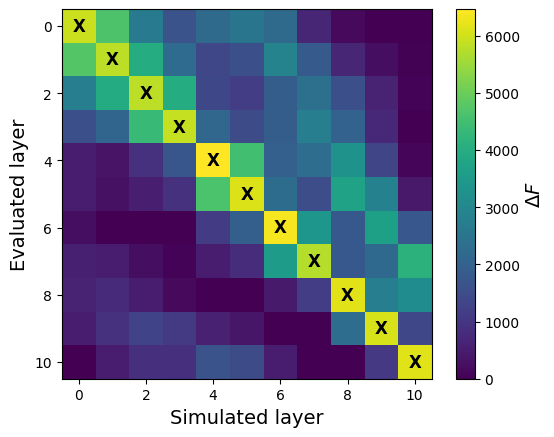

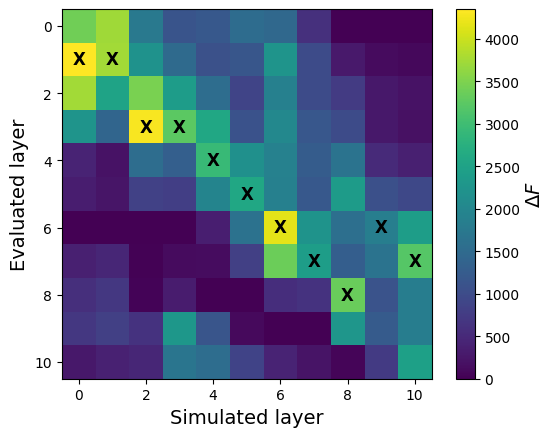

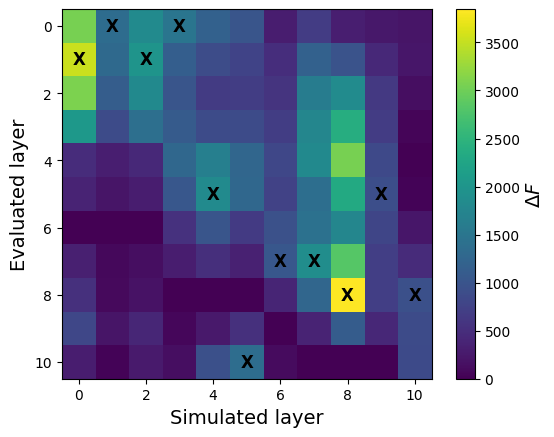

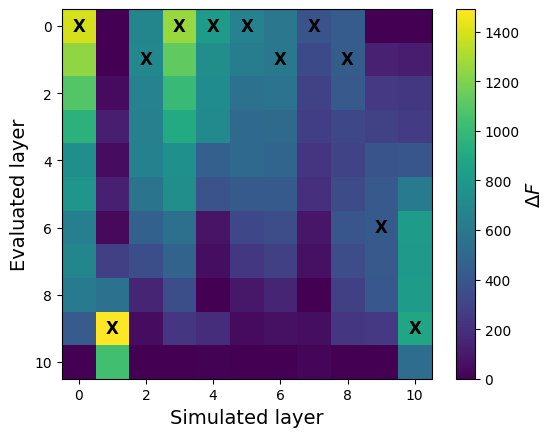

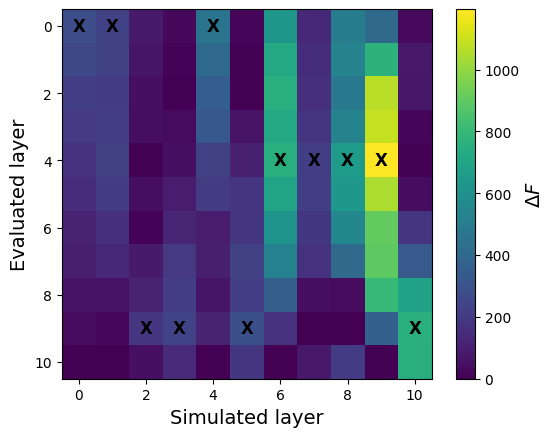

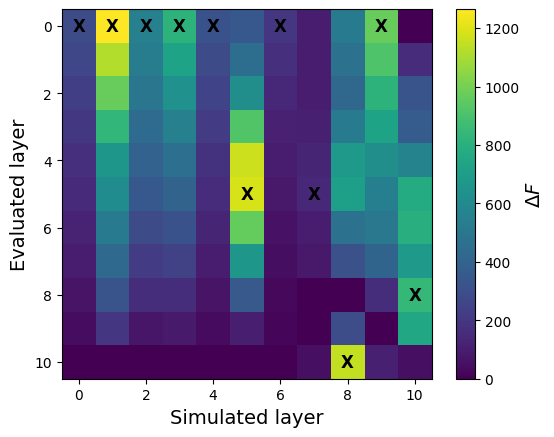

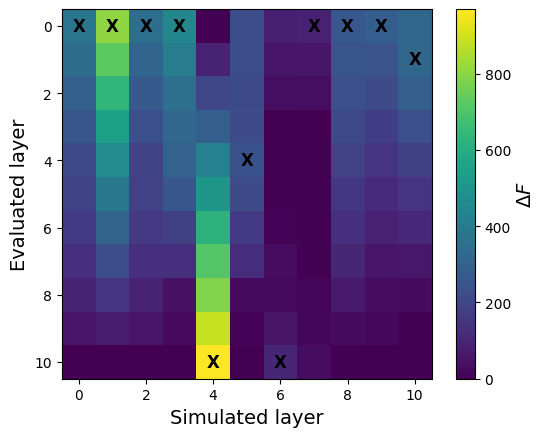

In [33]:
for err_idx, err in enumerate(err_levels):
    all_layerF=err_layerF[err_idx,:,:]
    # Normalization step
    norm_layerF = np.zeros(all_layerF.shape)
    for l in range(n_layers):
        norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])

    plt.figure()
    # Transpose for visualization
    im=plt.imshow(norm_layerF.T)

    # Find the indices of the max value in each column
    max_indices = np.argmax(norm_layerF, axis=1)

    # Plot an 'X' at the center of the square for each column's maximum
    for idx, max_idx in enumerate(max_indices):
        plt.text(idx, max_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

    plt.xlabel('Simulated layer', fontsize=14)
    plt.ylabel('Evaluated layer', fontsize=14)
    cb=plt.colorbar(im)
    cb.set_label(r'$\Delta F$', fontsize=14)

In [6]:
def diagonal_off_diagonal_ratio(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    # Extract diagonal elements
    diagonal_elements = np.diag(matrix)
    
    # Compute the 2-norm of diagonal elements
    diagonal_norm = np.linalg.norm(diagonal_elements)
    
    # Compute the Frobenius norm of the entire matrix
    total_norm = np.linalg.norm(matrix, ord='fro')
    
    # Calculate the norm of off-diagonal elements
    off_diagonal_norm = np.sqrt(total_norm**2 - diagonal_norm**2)
    
    # Calculate the ratio
    ratio = diagonal_norm / off_diagonal_norm if off_diagonal_norm != 0 else np.inf
    
    return ratio

def fraction_not_skew_symmetric(A):
    # Compute the skew-symmetric part of A
    skew_symmetric_part = (A - A.T) / 2
    
    # Compute the Frobenius norm of the original matrix
    frobenius_norm_A = np.linalg.norm(A, 'fro')
    
    # Compute the Frobenius norm of the skew-symmetric part
    frobenius_norm_skew = np.linalg.norm(skew_symmetric_part, 'fro')
    
    # Calculate the fraction of the total energy that is not skew-symmetric
    fraction_not_skew = 1 - (frobenius_norm_skew / (np.sqrt(2) * frobenius_norm_A))**2
    
    return fraction_not_skew

def correlation_coefficient(matrix):
    d = matrix.shape[0]
    j = np.ones(d)
    r = np.arange(1, d + 1)

    # Compute the sum of all entries in the matrix
    n = np.sum(matrix)

    # Compute ?x, ?y, ?x^2, ?y^2, and ?xy using matrix A and vectors r and j
    sum_x = np.dot(r, np.dot(matrix, j))
    sum_y = np.dot(j, np.dot(matrix, r))
    sum_x2 = np.dot(r**2, np.dot(matrix, j))
    sum_y2 = np.dot(j, np.dot(matrix, r**2))
    sum_xy = np.dot(r, np.dot(matrix, r))

    # Compute the numerator and denominator for the correlation coefficient
    numerator = n * sum_xy - sum_x * sum_y
    denominator = np.sqrt(n * sum_x2 - sum_x**2) * np.sqrt(n * sum_y2 - sum_y**2)

    # Calculate the correlation coefficient
    correlation = numerator / denominator

    return correlation

def triangular_dominance(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    n = matrix.shape[0]
    
    # Extract the upper and lower triangular parts, excluding the diagonal
    upper_triangular = np.triu(matrix, k=1)
    lower_triangular = np.tril(matrix, k=-1)
    
    # Sum the upper and lower triangular parts
    upper_sum = np.sum(upper_triangular)
    lower_sum = np.sum(lower_triangular)
    
    # Calculate the dominance metric
    dominance = (lower_sum-upper_sum) / (upper_sum + lower_sum)
    
    return dominance


def overall_accuracy(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        raise ValueError("The input matrix must be square.")
    
    n = matrix.shape[0]
    correct_columns = 0
    
    # Loop through each column and check if the maximum value is on the diagonal
    for j in range(n):
        max_index = np.argmax(matrix[:, j])
        if max_index == j:
            correct_columns += 1
    
    # Calculate the percentage of correct columns
    accuracy = (correct_columns / n) * 100
    
    return accuracy

Text(0, 0.5, 'Diagonality')

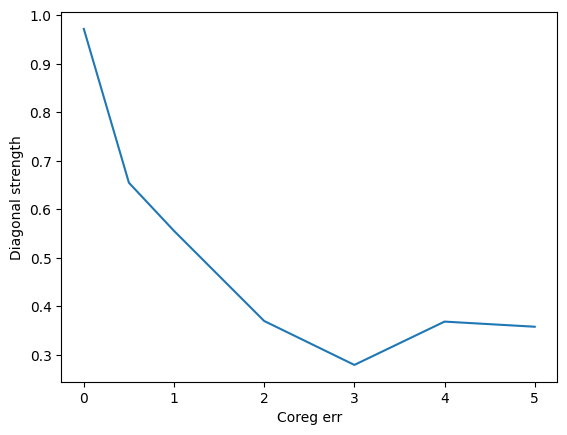

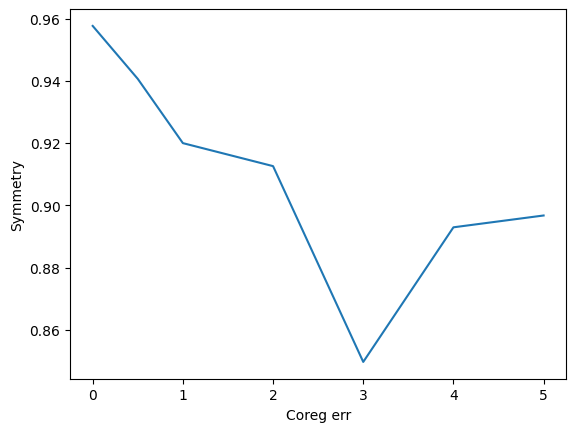

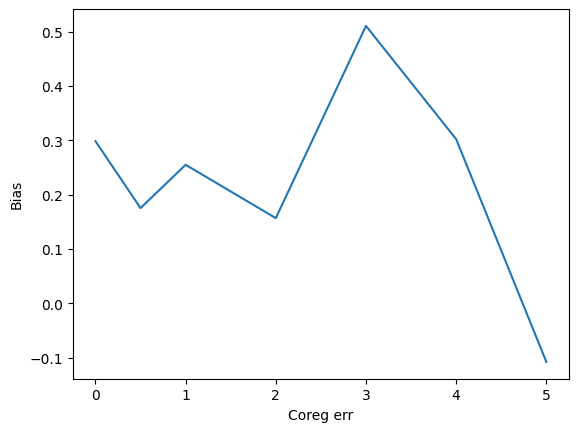

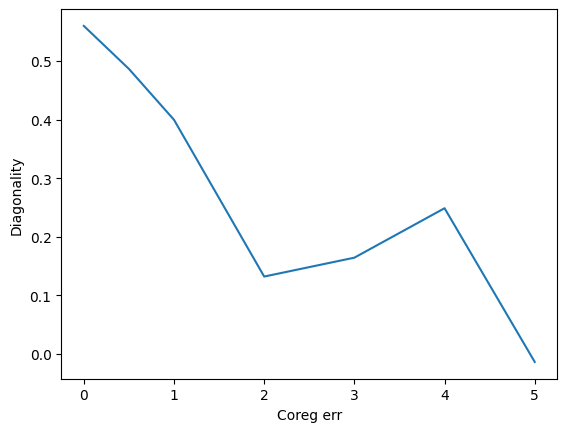

In [35]:
err_ratios=[]
err_fractions=[]
err_correlations=[]
err_biases=[]
for err_idx, err in enumerate(err_levels):
    all_layerF=err_layerF[err_idx,:,:]
    # Normalization step
    norm_layerF = np.zeros(all_layerF.shape)
    for l in range(n_layers):
        norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])
        
    err_ratios.append(diagonal_off_diagonal_ratio(norm_layerF))
    err_fractions.append(fraction_not_skew_symmetric(norm_layerF))
    err_correlations.append(correlation_coefficient(norm_layerF))
    err_biases.append(triangular_dominance(norm_layerF))
    
plt.figure()
plt.plot(err_levels, err_ratios)
plt.xlabel('Coreg err')
plt.ylabel('Diagonal strength')

plt.figure()
plt.plot(err_levels, err_fractions)
plt.xlabel('Coreg err')
plt.ylabel('Symmetry')

plt.figure()
plt.plot(err_levels, err_biases)
plt.xlabel('Coreg err')
plt.ylabel('Bias')

plt.figure()
plt.plot(err_levels, err_correlations)
plt.xlabel('Coreg err')
plt.ylabel('Diagonality')

In [3]:
out_dir='../output/coreg_err_simulations'
n_layers=11



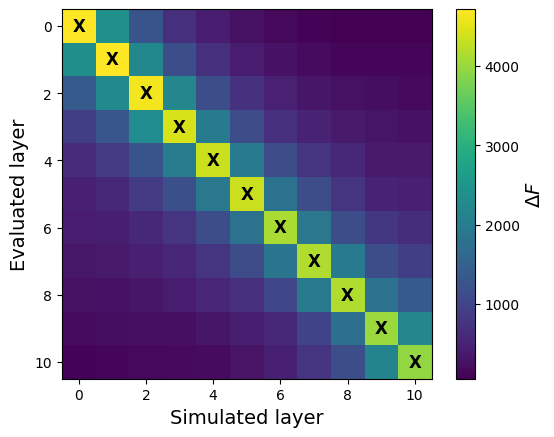

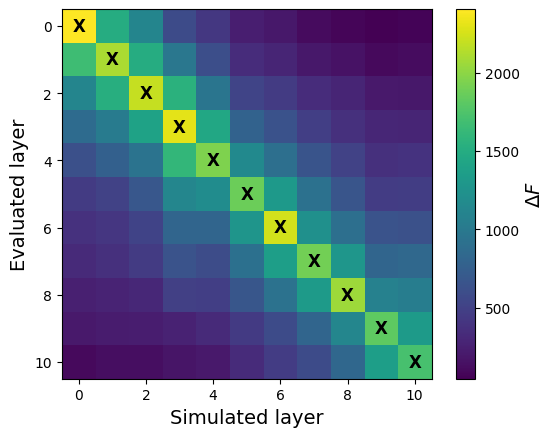

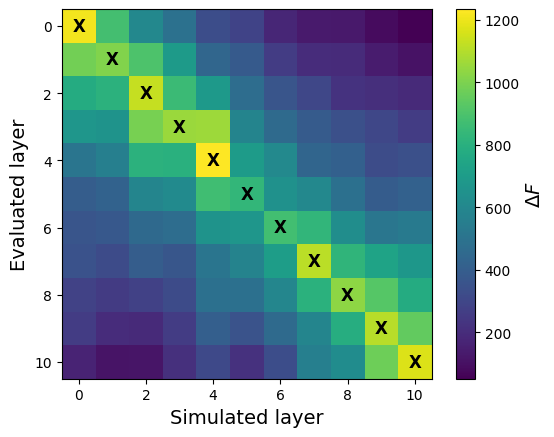

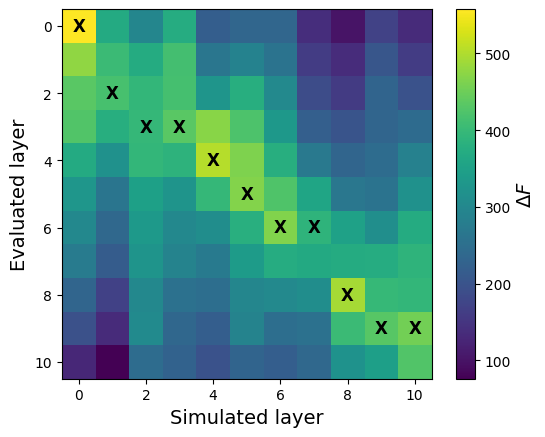

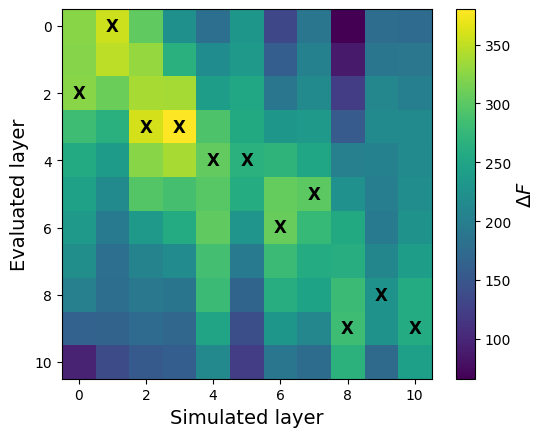

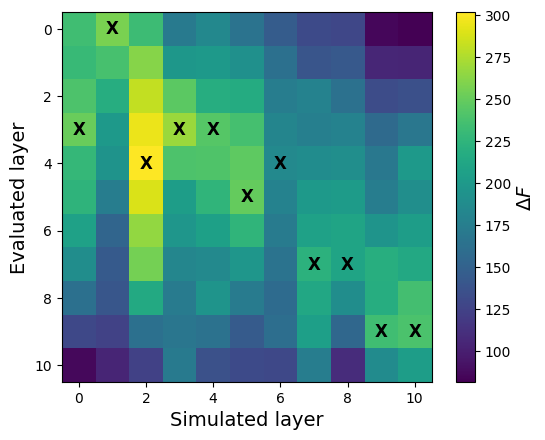

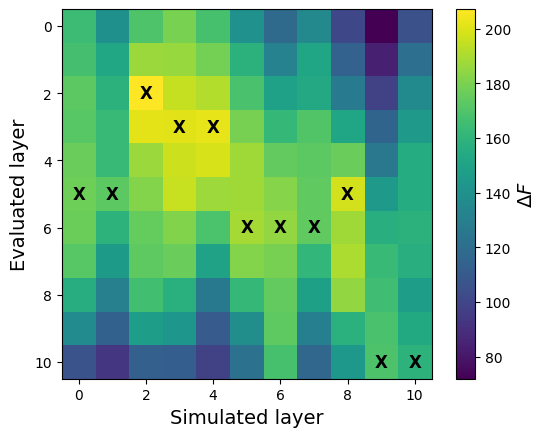

In [27]:
n_sims=50
diagonality=np.zeros((len(err_levels),n_sims))
diag_strength=np.zeros((len(err_levels),n_sims))
bias=np.zeros((len(err_levels),n_sims))
accuracy=np.zeros((len(err_levels),n_sims))


n_iter=100
diagonality_shuf=np.zeros((len(err_levels),n_sims,n_iter))
diag_strength_shuf=np.zeros((len(err_levels),n_sims,n_iter))
bias_shuf=np.zeros((len(err_levels),n_sims,n_iter))
accuracy_shuf=np.zeros((len(err_levels),n_sims,n_iter))


for err_idx, err in enumerate(err_levels):
    fnames=sorted(glob.glob(os.path.join(out_dir, f'*err_{err}.pickle')))
    m_norm_layerF=[]
    for f_idx, fname in enumerate(fnames):
        with open(fname,'rb') as file:
            results=pickle.load(file)
        all_layerF=results['all_layerF']
        # Normalization step
        norm_layerF = np.zeros(all_layerF.shape)
        for l in range(n_layers):
            norm_layerF[l,:] = all_layerF[l,:] - np.min(all_layerF[l,:])
                    
        diagonality[err_idx, f_idx] = correlation_coefficient(norm_layerF)
        diag_strength[err_idx, f_idx] = diagonal_off_diagonal_ratio(norm_layerF)
        bias[err_idx, f_idx] = triangular_dominance(norm_layerF)
        accuracy[err_idx, f_idx] = overall_accuracy(norm_layerF)
        m_norm_layerF.append(norm_layerF)
        
        for s_idx in range(n_iter):
            shuff_layerF=norm_layerF[np.random.permutation(np.arange(n_layers)),:]
            shuff_layerF=shuff_layerF[:,np.random.permutation(np.arange(n_layers))]
            diagonality_shuf[err_idx, f_idx, s_idx] = correlation_coefficient(shuff_layerF)
            diag_strength_shuf[err_idx, f_idx, s_idx] = diagonal_off_diagonal_ratio(shuff_layerF)
            bias_shuf[err_idx, f_idx, s_idx] = triangular_dominance(shuff_layerF)
            accuracy_shuf[err_idx, f_idx, s_idx] = overall_accuracy(shuff_layerF)
        
    m_norm_layerF=np.mean(np.array(m_norm_layerF),axis=0)
    
    plt.figure()
    # Transpose for visualization
    im=plt.imshow(m_norm_layerF.T)

    # Find the indices of the max value in each column
    max_indices = np.argmax(m_norm_layerF, axis=1)

    # Plot an 'X' at the center of the square for each column's maximum
    for idx, max_idx in enumerate(max_indices):
        plt.text(idx, max_idx, 'X', fontsize=12, ha='center', va='center', color='black', weight='bold')

    plt.xlabel('Simulated layer', fontsize=14)
    plt.ylabel('Evaluated layer', fontsize=14)
    cb=plt.colorbar(im)
    cb.set_label(r'$\Delta F$', fontsize=14)


In [28]:
lci_diagonality=np.percentile(diagonality_shuf.reshape(len(err_levels),-1), 5, axis=-1)
mci_diagonality=np.percentile(diagonality_shuf.reshape(len(err_levels),-1), 50, axis=-1)
uci_diagonality=np.percentile(diagonality_shuf.reshape(len(err_levels),-1), 95, axis=-1)

lci_diag_strength=np.percentile(diag_strength_shuf.reshape(len(err_levels),-1), 5, axis=-1)
mci_diag_strength=np.percentile(diag_strength_shuf.reshape(len(err_levels),-1), 50, axis=-1)
uci_diag_strength=np.percentile(diag_strength_shuf.reshape(len(err_levels),-1), 95, axis=-1)

lci_bias=np.percentile(bias_shuf.reshape(len(err_levels),-1), 5, axis=-1)
mci_bias=np.percentile(bias_shuf.reshape(len(err_levels),-1), 50, axis=-1)
uci_bias=np.percentile(bias_shuf.reshape(len(err_levels),-1), 95, axis=-1)

lci_accuracy=np.percentile(accuracy_shuf.reshape(len(err_levels),-1), 5, axis=-1)
mci_accuracy=np.percentile(accuracy_shuf.reshape(len(err_levels),-1), 50, axis=-1)
uci_accuracy=np.percentile(accuracy_shuf.reshape(len(err_levels),-1), 95, axis=-1)

Text(0, 0.5, 'Accuracy')

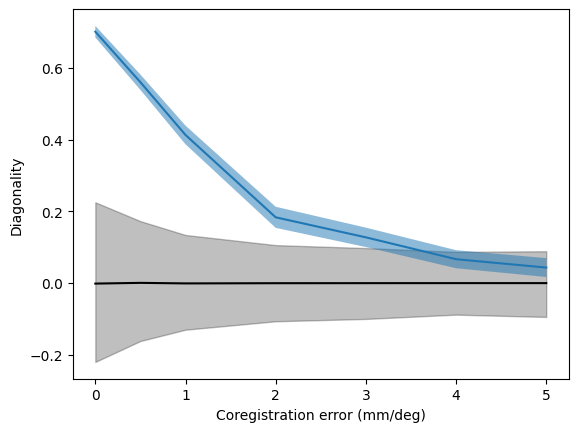

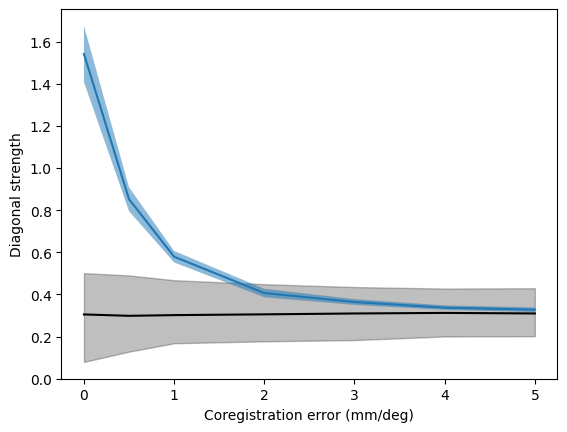

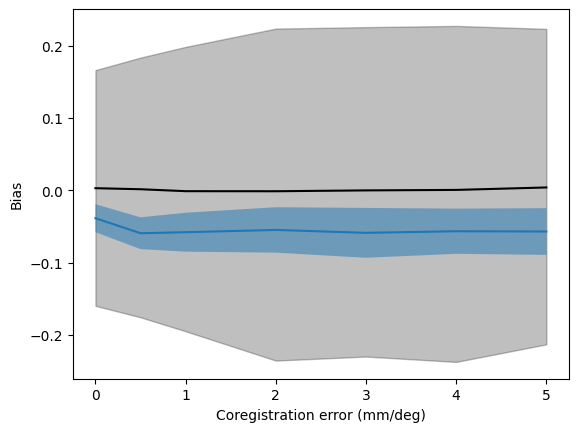

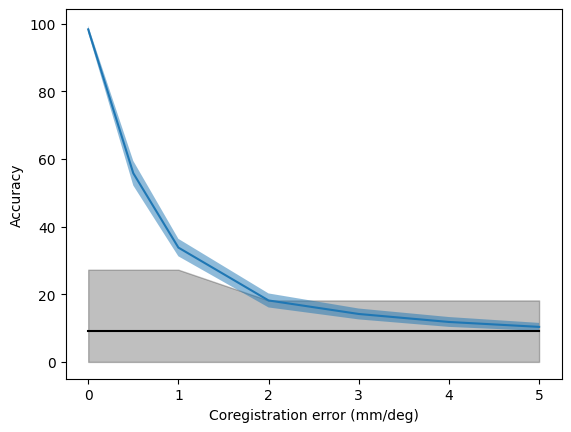

In [29]:
m_diagonality = np.mean(diagonality, axis=-1)
se_diagonality = np.std(diagonality, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(err_levels, mci_diagonality, color='k')
plt.fill_between(err_levels, lci_diagonality, uci_diagonality, alpha=0.25, color='k')
plt.plot(err_levels, m_diagonality)
plt.fill_between(err_levels, m_diagonality-se_diagonality, m_diagonality+se_diagonality,alpha=0.5)
plt.xlabel('Coregistration error (mm/deg)')
plt.ylabel('Diagonality')

m_diag_strength = np.mean(diag_strength, axis=-1)
se_diag_strength = np.std(diag_strength, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(err_levels, mci_diag_strength, color='k')
plt.fill_between(err_levels, lci_diag_strength, uci_diag_strength, alpha=0.25, color='k')
plt.plot(err_levels, m_diag_strength)
plt.fill_between(err_levels, m_diag_strength-se_diag_strength, m_diag_strength+se_diag_strength,alpha=0.5)
plt.xlabel('Coregistration error (mm/deg)')
plt.ylabel('Diagonal strength')

m_bias = np.mean(bias, axis=-1)
se_bias = np.std(bias, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(err_levels, mci_bias, color='k')
plt.fill_between(err_levels, lci_bias, uci_bias, alpha=0.25, color='k')
plt.plot(err_levels, m_bias)
plt.fill_between(err_levels, m_bias-se_bias, m_bias+se_bias,alpha=0.5)
plt.xlabel('Coregistration error (mm/deg)')
plt.ylabel('Bias')

m_accuracy = np.mean(accuracy, axis=-1)
se_accuracy = np.std(accuracy, axis=-1)/np.sqrt(n_sims)
plt.figure()
plt.plot(err_levels, mci_accuracy, color='k')
plt.fill_between(err_levels, lci_accuracy, uci_accuracy, alpha=0.25, color='k')
plt.plot(err_levels, m_accuracy)
plt.fill_between(err_levels, m_accuracy-se_accuracy, m_accuracy+se_accuracy,alpha=0.5)
plt.xlabel('Coregistration error (mm/deg)')
plt.ylabel('Accuracy')

In [77]:
n_iter=1000
dists=np.zeros((len(err_levels),n_iter))
for e_idx, err in enumerate(err_levels):
    for i in range(n_iter):
        # Translation vector
        translation = err
        shift_vec = np.random.randn(3)
        shift_vec = shift_vec / np.linalg.norm(shift_vec) * translation

        # Rotation vector
        rotation_rad = err * np.pi / 180.0
        rot_vec = np.random.randn(3)
        rot_vec = rot_vec / np.linalg.norm(rot_vec) * rotation_rad

        # Apply transformation to fiducial locations
        P = np.concatenate((shift_vec, rot_vec))
        rotation = R.from_rotvec(P[3:])
        rotation_matrix = rotation.as_matrix()
        A = np.eye(4)
        A[:3, :3] = rotation_matrix
        A[:3, 3] = P[:3]

        # Transform zero_mean_fid
        new_fid_homogeneous = (A @ zero_mean_fid.T).T
        new_fid = new_fid_homogeneous[:, :3] + mean_fid
        dists[e_idx,i]=np.max(np.sqrt(np.sum((new_fid-orig_fid)**2,axis=-1)))

Text(0.5, 0, 'Max distance to original fiducials (mm)')

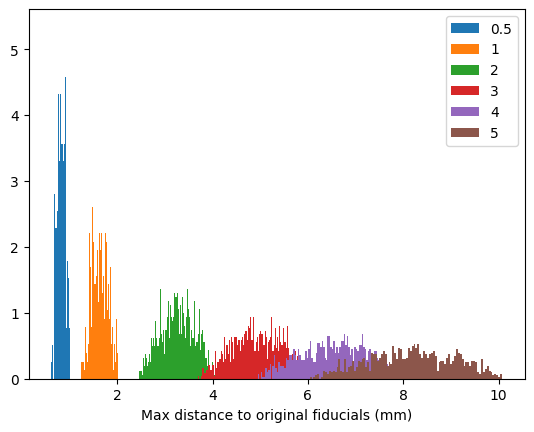

In [78]:
for i in range(1,len(err_levels)):
    _=plt.hist(dists[i,:],100,density=True,label=err_levels[i])
plt.legend()
plt.xlabel('Max distance to original fiducials (mm)')

In [79]:
n_iter=1000
dists=np.zeros((len(err_levels),n_iter))
for e_idx, err in enumerate(err_levels):
    print(e_idx)
    for i in range(n_iter):
        for j in range(1000):
            # Translation vector
            translation = err
            shift_vec = np.random.randn(3)
            shift_vec = shift_vec / np.linalg.norm(shift_vec) * np.random.randn()*translation

            # Rotation vector
            rotation_rad = err * np.pi / 180.0
            rot_vec = np.random.randn(3)
            rot_vec = rot_vec / np.linalg.norm(rot_vec) * np.random.randn()*rotation_rad

            # Apply transformation to fiducial locations
            P = np.concatenate((shift_vec, rot_vec))
            rotation = R.from_rotvec(P[3:])
            rotation_matrix = rotation.as_matrix()
            A = np.eye(4)
            A[:3, :3] = rotation_matrix
            A[:3, 3] = P[:3]

            # Transform zero_mean_fid
            new_fid_homogeneous = (A @ zero_mean_fid.T).T
            new_fid = new_fid_homogeneous[:, :3] + mean_fid
            max_dist=np.max(np.sqrt(np.sum((new_fid-orig_fid)**2,axis=-1)))
            if np.abs(err-max_dist)<.1:
                dists[e_idx,i]=max_dist
                break

0
1
2
3
4
5
6


Text(0.5, 0, 'Max distance to original fiducials (mm)')

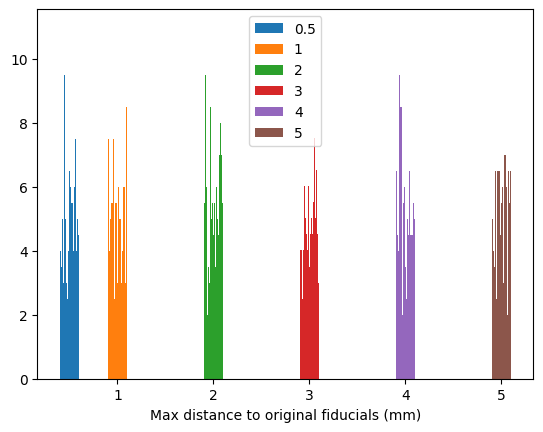

In [83]:
for i in range(1,len(err_levels)):
    _=plt.hist(dists[i,:],100,density=True,label=err_levels[i])
plt.legend()
plt.xlabel('Max distance to original fiducials (mm)')

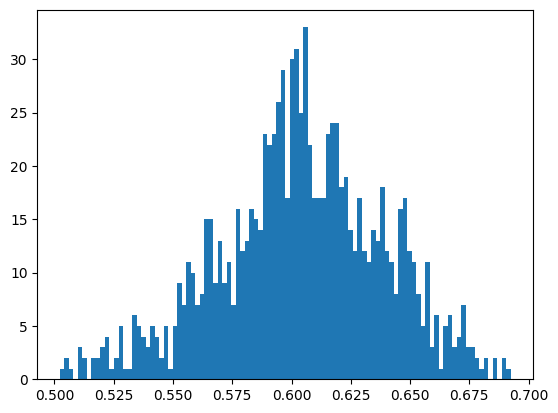

In [51]:
_=plt.hist(dists[1,:],100)

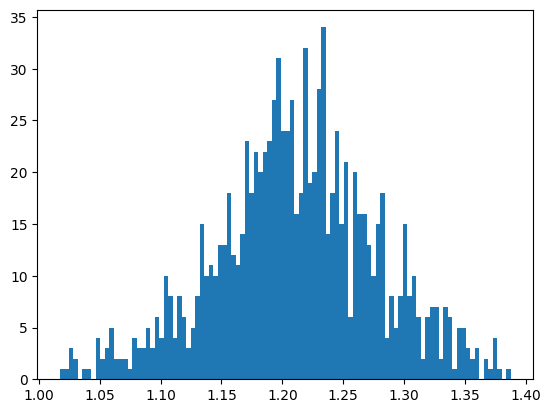

In [52]:
_=plt.hist(dists[2,:],100)

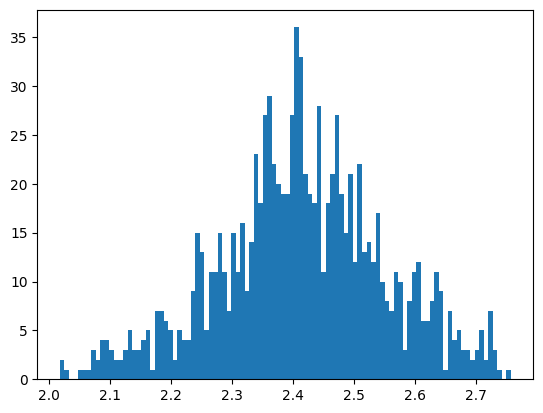

In [53]:
_=plt.hist(dists[3,:],100)

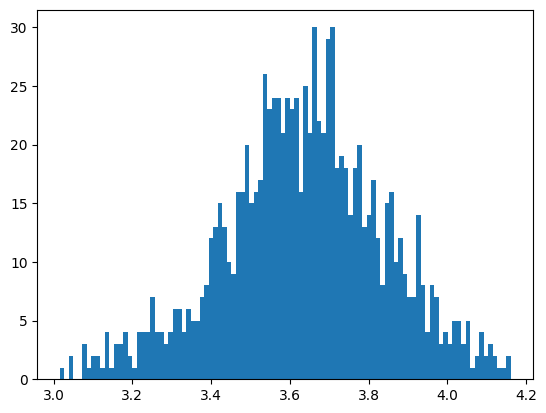

In [54]:
_=plt.hist(dists[4,:],100)

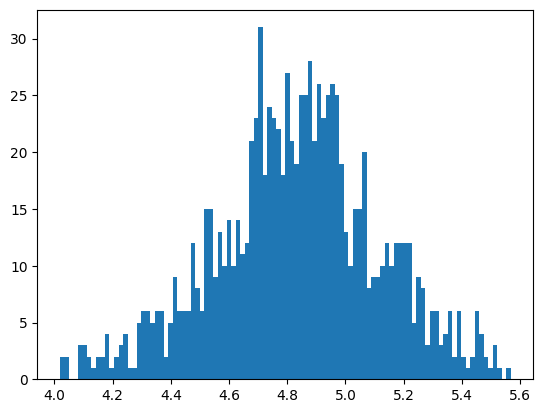

In [55]:
_=plt.hist(dists[5,:],100)

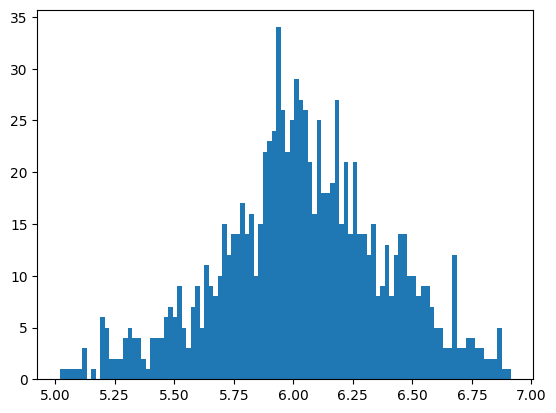

In [56]:
_=plt.hist(dists[6,:],100)